In [25]:
# CELL 1: Imports and State Definition

from typing import TypedDict, Literal, Optional, List, Dict, Any
from langgraph.graph import StateGraph, END
import json
import re
import logging
import os
from datetime import datetime, timedelta
from dotenv import load_dotenv
import google.generativeai as genai

# Load environment variables - handle both notebook and script execution
try:
    # For notebooks - get current working directory and navigate to .env
    env_path = r'D:\codecrafters\EY_CodeCrafters\backend\.env'
    if os.path.exists(env_path):
        load_dotenv(env_path)
        print(f"✓ Loaded .env from: {env_path}")
    else:
        # Try relative path from current directory
        possible_paths = [
            os.path.join(os.getcwd(), '..', '..', '.env'),
            os.path.join(os.getcwd(), '.env'),
            '../.env',
            '../../.env'
        ]
        loaded = False
        for path in possible_paths:
            if os.path.exists(path):
                load_dotenv(path)
                print(f"✓ Loaded .env from: {os.path.abspath(path)}")
                loaded = True
                break
        if not loaded:
            print("⚠ .env file not found, trying from environment")
            load_dotenv()
except Exception as e:
    print(f"⚠ Error loading .env: {e}")
    load_dotenv()

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Configure Gemini API
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
if GEMINI_API_KEY:
    genai.configure(api_key=GEMINI_API_KEY)
    logger.info("✓ Gemini API configured")
    print(f"✓ Gemini API Key found.")
else:
    logger.warning("⚠ GEMINI_API_KEY not found - falling back to keyword matching only")
    print("⚠ GEMINI_API_KEY not found in environment")
    print("Please ensure GEMINI_API_KEY is set in backend/.env")

# Define the Sales Agent State
class SalesState(TypedDict):
    """
    Complete state for the sales agent workflow.
    Tracks conversation context, cart, user info, and worker responses.
    """
    # User message and conversation
    user_message: str
    conversation_history: List[Dict[str, str]]
    
    # Intent and routing
    detected_intent: str
    confidence: float
    
    # Shopping context
    cart: List[Dict[str, Any]]  # [{"sku": "...", "name": "...", "price": float, "qty": int}]
    user_id: Optional[str]
    
    # Worker response
    worker_response: str
    cards: List[Dict[str, Any]]  # Visual cards for frontend
    
    # Metadata
    metadata: Dict[str, Any]
    session_token: str
    timestamp: str

print("✓ State definition loaded")
print("✓ Logging configured")

2025-12-17 13:06:12,398 - __main__ - INFO - ✓ Gemini API configured


✓ Loaded .env from: /Users/riddhij08/Project/EY/EY_CodeCrafters/backend/.env
✓ Gemini API Key found.
✓ State definition loaded
✓ Logging configured


In [26]:
# CELL: Redis Session Management

import redis
from typing import Optional

# Redis Configuration
REDIS_URL = os.getenv("REDIS_URL")
SESSION_TTL = 3600  # 1 hour in seconds

# Initialize Redis client with fallback
redis_client = None
redis_available = False

try:
    if REDIS_URL:
        # Upstash Redis URL already contains the password
        redis_client = redis.from_url(
            REDIS_URL,
            decode_responses=True,
            socket_connect_timeout=5
        )
        # Test connection
        redis_client.ping()
        redis_available = True
        logger.info("✓ Redis connected successfully")
        print("✓ Redis connected (Upstash)")
    else:
        logger.warning("⚠ Redis URL not found, using in-memory fallback")
        print("⚠ Redis not configured - using in-memory storage")
except Exception as e:
    logger.error(f"Redis connection failed: {e}")
    print(f"⚠ Redis unavailable: {e}")
    print("Using in-memory fallback")
    redis_available = False

# In-memory fallback storage
memory_sessions = {}


def load_session(session_token: str) -> Optional[Dict[str, Any]]:
    """
    Load session data from Redis or memory fallback.
    
    Args:
        session_token: Unique session identifier
    
    Returns:
        Session dict or None if not found
    """
    try:
        if redis_available and redis_client:
            session_json = redis_client.get(f"session:{session_token}")
            if session_json:
                session_data = json.loads(session_json)
                logger.info(f"Session loaded from Redis: {session_token}")
                return session_data
            return None
        else:
            # Memory fallback
            session = memory_sessions.get(session_token)
            if session:
                logger.info(f"Session loaded from memory: {session_token}")
            return session
    except Exception as e:
        logger.error(f"Failed to load session {session_token}: {e}")
        return memory_sessions.get(session_token)


def save_session(session_token: str, session_data: Dict[str, Any]) -> bool:
    """
    Save session data to Redis or memory fallback.
    Refreshes TTL on each save.
    
    Args:
        session_token: Unique session identifier
        session_data: Session dictionary to persist
    
    Returns:
        True if successful, False otherwise
    """
    try:
        if redis_available and redis_client:
            session_json = json.dumps(session_data, default=str)
            redis_client.setex(
                f"session:{session_token}",
                SESSION_TTL,
                session_json
            )
            logger.info(f"Session saved to Redis: {session_token} (TTL: {SESSION_TTL}s)")
            return True
        else:
            # Memory fallback
            memory_sessions[session_token] = session_data
            logger.info(f"Session saved to memory: {session_token}")
            return True
    except Exception as e:
        logger.error(f"Failed to save session {session_token}: {e}")
        # Emergency fallback to memory
        memory_sessions[session_token] = session_data
        return False


def create_session(session_token: str, user_id: str = "user_123") -> Dict[str, Any]:
    """
    Create a new session with default schema.
    
    Args:
        session_token: Unique session identifier
        user_id: User identifier
    
    Returns:
        New session dictionary
    """
    new_session = {
        "session_token": session_token,
        "user_id": user_id,
        "created_at": datetime.now().isoformat(),
        "updated_at": datetime.now().isoformat(),
        "conversation_history": [],
        "cart": [],
        "metadata": {}
    }
    
    save_session(session_token, new_session)
    logger.info(f"New session created: {session_token}")
    
    return new_session


def session_to_state(session: Dict[str, Any], user_message: str) -> SalesState:
    """
    Convert session data to SalesState for LangGraph processing.
    
    Args:
        session: Session dictionary from Redis/memory
        user_message: Current user message
    
    Returns:
        SalesState ready for graph execution
    """
    return {
        "user_message": user_message,
        "conversation_history": session.get("conversation_history", []),
        "detected_intent": "",
        "confidence": 0.0,
        "cart": session.get("cart", []),
        "user_id": session.get("user_id", "user_123"),
        "worker_response": "",
        "cards": [],
        "metadata": session.get("metadata", {}),
        "session_token": session["session_token"],
        "timestamp": datetime.now().isoformat()
    }


def state_to_session(state: SalesState) -> Dict[str, Any]:
    """
    Convert SalesState back to session format for persistence.
    
    Args:
        state: SalesState after graph execution
    
    Returns:
        Session dictionary ready to save
    """
    return {
        "session_token": state["session_token"],
        "user_id": state.get("user_id", "user_123"),
        "created_at": datetime.now().isoformat(),  # Preserve in real implementation
        "updated_at": datetime.now().isoformat(),
        "conversation_history": state.get("conversation_history", []),
        "cart": state.get("cart", []),
        "metadata": state.get("metadata", {})
    }

print("✓ Redis session management loaded")
print(f"✓ Redis available: {redis_available}")
print(f"✓ Session TTL: {SESSION_TTL} seconds")
print("✓ Helper functions: load_session, save_session, create_session")
print("✓ Mapping functions: session_to_state, state_to_session")

2025-12-17 13:06:13,101 - __main__ - INFO - ✓ Redis connected successfully


✓ Redis connected (Upstash)
✓ Redis session management loaded
✓ Redis available: True
✓ Session TTL: 3600 seconds
✓ Helper functions: load_session, save_session, create_session
✓ Mapping functions: session_to_state, state_to_session


## Redis Session Management

Initialize Redis client and define session persistence functions.

## Intent Detection & Entity Extraction

3-tier intent detection: Groq API → Gemini API → Keyword-based fallback
Extracts structured entities for each worker agent contract

In [27]:
# CELL 5: COMPREHENSIVE INTENT DETECTION SYSTEM

from groq import Groq
import re
import json
from typing import Optional, Dict, Any, List, TypedDict
import os
import logging

logger = logging.getLogger(__name__)

# Initialize Groq client
GROQ_API_KEY = os.getenv('GROQ_API_KEY')
groq_client = Groq(api_key=GROQ_API_KEY) if GROQ_API_KEY else None

# Define all possible intents (6 categories)
INTENT_CATEGORIES = {
    "recommendation": ["search", "looking for", "find", "recommend", "suggest", "show me", "dikhao", "chahiye", "gift", "trending"],
    "inventory": ["stock", "available", "in stock", "inventory", "do you have", "hai kya", "milega", "sku"],
    "loyalty": ["discount", "promo", "coupon", "deal", "loyalty", "points", "rewards", "offer", "bachat"],
    "payment": ["checkout", "pay", "purchase", "buy", "payment", "card", "paisa", "bill", "upi"],
    "fulfillment": ["delivery", "shipping", "track", "order status", "when will", "kab milega", "deliver"],
    "post_purchase": ["return", "refund", "exchange", "complaint", "issue", "problem", "wapas"]
}

# Define recommendation sub-modes
MODE_KEYWORDS = {
    "gifting_genius": ["gift", "present", "birthday", "anniversary", "mother", "father", "sister", "brother", "friend", "girlfriend", "boyfriend", "wife", "husband"],
    "trendseer": ["trending", "trend", "popular", "what's hot", "fashion", "latest", "viral", "everyone wearing"]
}

# IntentResult TypedDict for structured output
class IntentResult(TypedDict):
    intent: str
    mode: Optional[str]
    confidence: float
    explanation: str
    method: str  # "groq", "gemini", "keyword"
    extracted_entities: Dict[str, Any]

def detect_recommendation_mode(message: str) -> Optional[str]:
    """Detect if message is for gifting or trendseer mode."""
    message_lower = message.lower()
    
    gifting_score = sum(1 for kw in MODE_KEYWORDS["gifting_genius"] if kw in message_lower)
    trendseer_score = sum(1 for kw in MODE_KEYWORDS["trendseer"] if kw in message_lower)
    
    if gifting_score > trendseer_score and gifting_score > 0:
        return "gifting_genius"
    elif trendseer_score > gifting_score and trendseer_score > 0:
        return "trendseer"
    else:
        return "normal"

def extract_entities_from_message(message: str, mode: Optional[str] = "normal", intent: Optional[str] = None) -> Dict[str, Any]:
    """
    Extract entities based on detected intent and mode.
    
    INVENTORY INTENT (CRITICAL FIX): STRICT 4-field format with proper extraction
    """
    message_lower = message.lower()
    entities = {}
    
    # INVENTORY INTENT - STRICT 4-FIELD FORMAT (CRITICAL FIX)
    if intent == "inventory":
        # ALWAYS initialize all 4 required fields
        entities = {
            "sku": None,
            "product_name": None,
            "brand": None,
            "clarification_required": True
        }
        
        # 1. SKU FIRST - Complete SKU000001 capture
        sku_match = re.search(r'\b(SKU\d{6})\b', message_lower, re.IGNORECASE)
        if sku_match:
            entities["sku"] = sku_match.group(1).upper()
            entities["clarification_required"] = False
            return entities  # SKU found = done
        
        # 2. BRAND extraction
        brand_map = {
            "reebok": "reebok", "puma": "puma", "nike": "nike", "adidas": "adidas"
        }
        for keyword, brand in brand_map.items():
            if keyword in message_lower:
                entities["brand"] = brand
                break
        
        # 3. PRODUCT_NAME extraction (enhanced with category keywords)
        product_keywords = {
            "flip flop": "flip flop", "sandal": "sandal", "sneaker": "sneaker",
            "shoe": "shoe", "shoes": "shoe", "shirt": "shirt", "jacket": "jacket",
            "bag": "bag", "backpack": "backpack", "cap": "cap", "hat": "hat",
            "perfume": "perfume", "fragrance": "fragrance", "cologne": "cologne"
        }
        for keyword, product_name in product_keywords.items():
            if keyword in message_lower:
                entities["product_name"] = product_name
                break
        
        # 4. clarification_required remains True (no SKU)
        return entities
    
    # NON-INVENTORY INTENTS (original logic unchanged)
    # Budget extraction
    budget_match = re.search(r'(?:under|below|less than|max|maximum|upto|up to)\s*(?:rs\.?|rupees?|₹)?\s*(\d+)', message_lower)
    if budget_match:
        entities["budget_max"] = int(budget_match.group(1))
        entities["budget_min"] = 0
    
    # Category extraction
    category_map = {
        "shoes": "Footwear", "shoe": "Footwear", "footwear": "Footwear",
        "flip flop": "Footwear", "sandal": "Footwear", "sneaker": "Footwear",
        "clothes": "Apparel", "shirt": "Apparel", "t-shirt": "Apparel", "pant": "Apparel",
        "track pant": "Apparel", "jacket": "Apparel", "topwear": "Apparel", "bottomwear": "Apparel",
        "perfume": "Personal Care", "fragrance": "Personal Care", "cologne": "Personal Care",
        "bag": "Accessories", "backpack": "Accessories", "cap": "Accessories", "hat": "Accessories"
    }
    for keyword, category in category_map.items():
        if keyword in message_lower:
            entities["category"] = category
            break
    
    # Occasion extraction (for normal mode)
    if any(word in message_lower for word in ["casual", "everyday", "daily"]):
        entities["occasion"] = "casual"
    elif any(word in message_lower for word in ["formal", "office", "professional", "work"]):
        entities["occasion"] = "formal"
    elif any(word in message_lower for word in ["sports", "gym", "fitness", "running", "workout"]):
        entities["occasion"] = "sports"
    elif any(word in message_lower for word in ["party", "night out", "celebration"]):
        entities["occasion"] = "party"
    
    # Mode-specific entity extraction
    if mode == "gifting_genius":
        # GIFTING MODE: Extract recipient gender (NOT customer gender)
        relation_map = {
            "father": "father", "dad": "father", "papa": "father",
            "mother": "mother", "mom": "mother", "mama": "mother",
            "brother": "brother", "bro": "brother",
            "sister": "sister", "sis": "sister",
            "friend": "friend", "girlfriend": "girlfriend", "boyfriend": "boyfriend",
            "wife": "wife", "husband": "husband"
        }
        for keyword, relation in relation_map.items():
            if keyword in message_lower:
                entities["recipient_relation"] = relation
                if relation in ["father", "dad", "papa", "brother", "boyfriend", "husband"]:
                    entities["recipient_gender"] = "male"
                elif relation in ["mother", "mom", "sister", "girlfriend", "wife"]:
                    entities["recipient_gender"] = "female"
                break
        
        if "recipient_gender" not in entities:
            if any(word in message_lower for word in ["for him", "for men", "for man", "for male", "for boy"]):
                entities["recipient_gender"] = "male"
            elif any(word in message_lower for word in ["for her", "for women", "for woman", "for female", "for girl", "for lady"]):
                entities["recipient_gender"] = "female"
        
        if any(word in message_lower for word in ["birthday", "bday"]):
            entities["occasion"] = "birthday"
        elif any(word in message_lower for word in ["anniversary", "anniversay"]):
            entities["occasion"] = "anniversary"
        elif any(word in message_lower for word in ["festival", "festive", "diwali", "holi", "christmas"]):
            entities["occasion"] = "festive"
        
        interests_found = []
        if any(word in message_lower for word in ["sports", "fitness", "gym", "athlete", "running"]):
            interests_found.append("sports")
        if any(word in message_lower for word in ["fashion", "trendy", "stylish", "fashionable"]):
            interests_found.append("fashion")
        if any(word in message_lower for word in ["elegant", "classy", "sophisticated"]):
            interests_found.append("elegant")
        if any(word in message_lower for word in ["casual", "relaxed", "comfortable"]):
            interests_found.append("casual")
        if any(word in message_lower for word in ["accessories", "jewelry", "watch", "watches"]):
            interests_found.append("accessories")
        if any(word in message_lower for word in ["shoes", "footwear", "sneakers"]):
            interests_found.append("footwear")
        if interests_found:
            entities["interests"] = interests_found
        
        if any(word in message_lower for word in ["safe", "one size", "accessories", "don't know size", "not sure size"]):
            entities["safe_sizes_only"] = True
        else:
            entities["safe_sizes_only"] = False
        
        brands_found = []
        if "reebok" in message_lower:
            brands_found.append("Reebok")
        if "puma" in message_lower:
            brands_found.append("Puma")
        if "nike" in message_lower:
            brands_found.append("Nike")
        if "adidas" in message_lower:
            brands_found.append("Adidas")
        if brands_found:
            entities["preferred_brands"] = brands_found
    
    else:
        if any(word in message_lower for word in ["men", "man", "male", "boy", "boys", "for me (male context)"]):
            entities["gender"] = "male"
        elif any(word in message_lower for word in ["women", "woman", "female", "girl", "girls", "ladies", "lady"]):
            entities["gender"] = "female"
        elif "unisex" in message_lower:
            entities["gender"] = "unisex"
        
        if mode == "trendseer" and "category" not in entities:
            entities["category"] = "Footwear"
    
    return entities

# [All detection functions remain IDENTICAL - no changes needed]
def detect_intent_with_groq(message: str, conversation_history: List[Dict[str, str]]) -> Optional[IntentResult]:
    if not groq_client:
        return None
    
    try:
        context = ""
        if conversation_history:
            recent = conversation_history[-3:]
            context = "Recent conversation:\n" + "\n".join([f"- {msg.get('role', 'user')}: {msg.get('message', '')}" for msg in recent])
        
        prompt = f"""You are an intent classifier for a Reebok retail sales chatbot (Indian English/Hinglish).

Available intents:
- recommendation: User wants product suggestions (normal search, gifting, or trending items)
- inventory: User checking stock availability ("hai kya", "milega", SKU queries)
- loyalty: User asking about discounts, offers, loyalty points ("bachat")
- payment: User wants to checkout, pay ("paisa", "UPI")
- fulfillment: User asking about delivery, shipping ("kab milega")
- post_purchase: User wants to return, exchange, complaint ("wapas")

Recommendation sub-modes (only for recommendation intent):
- gifting_genius: User wants to gift something (mentions "gift", "mother", "father", etc.)
- trendseer: User wants trending/popular items ("trending", "what's hot", "latest")
- normal: Regular product search

{context}

Message: "{message}"

Respond ONLY with valid JSON:
{{"intent": "intent_name", "mode": "normal|gifting_genius|trendseer|null", "confidence": 0.0-1.0, "explanation": "brief reason"}}"""

        response = groq_client.chat.completions.create(
            model="llama-3.3-70b-versatile",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.3,
            max_tokens=200
        )
        
        result_text = response.choices[0].message.content.strip()
        result_json = json.loads(result_text)
        
        intent = result_json.get("intent", "recommendation").lower()
        mode = result_json.get("mode") if result_json.get("mode") != "null" else None
        confidence = float(result_json.get("confidence", 0.8))
        explanation = result_json.get("explanation", "Detected via Groq")
        
        entities = extract_entities_from_message(message, mode, intent)
        
        logger.info(f"✓ Groq detected: {intent} (mode: {mode}, conf: {confidence:.2f})")
        return {
            "intent": intent,
            "mode": mode,
            "confidence": confidence,
            "explanation": explanation,
            "method": "groq",
            "extracted_entities": entities
        }
    
    except Exception as e:
        logger.error(f"Groq detection failed: {e}")
        return None

def detect_intent_with_gemini(message: str, conversation_history: List[Dict[str, str]]) -> Optional[IntentResult]:
    try:
        if 'GEMINI_API_KEY' not in globals() or not GEMINI_API_KEY:
            return None
    except:
        return None
    
    try:
        import google.generativeai as genai
        model = genai.GenerativeModel('gemini-1.5-flash')
        
        context = ""
        if conversation_history:
            recent = conversation_history[-3:]
            context = "Recent conversation:\n" + "\n".join([f"- {msg.get('role', 'user')}: {msg.get('message', '')}" for msg in recent])
        
        prompt = f"""You are an intent classifier for a Reebok retail sales chatbot (Indian English/Hinglish).

Available intents:
- recommendation: User wants product suggestions
- inventory: Stock availability queries
- loyalty: Discounts, offers, loyalty points
- payment: Checkout, payment
- fulfillment: Delivery, shipping tracking
- post_purchase: Returns, exchanges, complaints

Recommendation modes (only for recommendation):
- gifting_genius: Gift shopping
- trendseer: Trending items
- normal: Regular search

{context}

Message: "{message}"

Respond with JSON: {{"intent": "intent_name", "mode": "mode|null", "confidence": 0.0-1.0, "explanation": "reason"}}"""

        response = model.generate_content(prompt)
        result_text = response.text.strip()
        
        json_match = re.search(r'\{.*\}', result_text, re.DOTALL)
        if json_match:
            result_json = json.loads(json_match.group())
            
            intent = result_json.get("intent", "recommendation").lower()
            mode = result_json.get("mode") if result_json.get("mode") != "null" else None
            confidence = float(result_json.get("confidence", 0.75))
            explanation = result_json.get("explanation", "Detected via Gemini")
            
            entities = extract_entities_from_message(message, mode, intent)
            
            logger.info(f"✓ Gemini detected: {intent} (mode: {mode}, conf: {confidence:.2f})")
            return {
                "intent": intent,
                "mode": mode,
                "confidence": confidence,
                "explanation": explanation,
                "method": "gemini",
                "extracted_entities": entities
            }
    
    except Exception as e:
        logger.error(f"Gemini detection failed: {e}")
        return None

def detect_intent_keyword(message: str) -> IntentResult:
    message_lower = message.lower()
    
    scores = {}
    for intent, keywords in INTENT_CATEGORIES.items():
        score = sum(1 for kw in keywords if kw in message_lower)
        scores[intent] = score
    
    best_intent = max(scores, key=scores.get)
    total_keywords = len(INTENT_CATEGORIES[best_intent])
    confidence = 0.5 + (scores[best_intent] / total_keywords * 0.45) if scores[best_intent] > 0 else 0.6
    
    mode = None
    if best_intent == "recommendation":
        mode = detect_recommendation_mode(message)
    
    entities = extract_entities_from_message(message, mode, best_intent)
    
    logger.info(f"✓ Keyword detected: {best_intent} (mode: {mode}, conf: {confidence:.2f})")

    return {
        "intent": best_intent,
        "mode": mode,
        "confidence": confidence,
        "explanation": f"Matched {scores[best_intent]} keywords for {best_intent}",
        "method": "keyword",
        "extracted_entities": entities
    }

def detect_intent(message: str, conversation_history: List[Dict[str, str]]) -> IntentResult:
    result = detect_intent_with_groq(message, conversation_history)
    if result:
        return result
    
    result = detect_intent_with_gemini(message, conversation_history)
    if result:
        return result
    
    return detect_intent_keyword(message)

print("✓ COMPREHENSIVE Intent Detection System loaded")
print(f"✓ 6 intents: {list(INTENT_CATEGORIES.keys())}")
print(f"✓ 3 modes: normal, gifting_genius, trendseer")
print(f"✓ Groq available: {groq_client is not None}")
print(f"✓ Gemini available: {'GEMINI_API_KEY' in globals()}")
print(f"✓ Cascading: Groq → Gemini → Keyword")
print(f"✓ INVENTORY FIXED: STRICT 4-field format + enhanced product extraction")


✓ COMPREHENSIVE Intent Detection System loaded
✓ 6 intents: ['recommendation', 'inventory', 'loyalty', 'payment', 'fulfillment', 'post_purchase']
✓ 3 modes: normal, gifting_genius, trendseer
✓ Groq available: True
✓ Gemini available: True
✓ Cascading: Groq → Gemini → Keyword
✓ INVENTORY FIXED: STRICT 4-field format + enhanced product extraction


In [28]:
# DEBUG: Check SDK version and list available models

import google.generativeai as genai

# 1. Check SDK version
print(f"SDK Version: {genai.__version__}")

# 2. List all available models
print("\n📋 Available Gemini Models:")
print("=" * 60)

try:
    for model in genai.list_models():
        if 'generateContent' in model.supported_generation_methods:
            print(f"✓ {model.name}")
            print(f"  Display Name: {model.display_name}")
            print(f"  Methods: {model.supported_generation_methods}")
            print()
except Exception as e:
    print(f"❌ Error listing models: {e}")
    
# 3. Test with correct model name
print("=" * 60)
print("\n🧪 Testing Gemini API with correct model...")

try:
    # CORRECT: Use model name without 'models/' prefix
    model = genai.GenerativeModel('gemini-1.5-flash')
    response = model.generate_content("Say 'Hello from Gemini!' in one sentence.")
    print(f"✅ Success! Response: {response.text}")
except Exception as e:
    print(f"❌ Test failed: {e}")
    
    # Try alternative model names
    print("\n🔄 Trying alternative models...")
    for model_name in ['gemini-pro', 'gemini-1.5-pro', 'gemini-1.0-pro']:
        try:
            model = genai.GenerativeModel(model_name)
            response = model.generate_content("Say 'Hello!'")
            print(f"✅ {model_name} works! Response: {response.text[:50]}")
            break
        except Exception as e2:
            print(f"❌ {model_name} failed: {str(e2)[:80]}")

print("\n" + "=" * 60)

SDK Version: 0.8.5

📋 Available Gemini Models:
✓ models/gemini-2.5-flash
  Display Name: Gemini 2.5 Flash
  Methods: ['generateContent', 'countTokens', 'createCachedContent', 'batchGenerateContent']

✓ models/gemini-2.5-pro
  Display Name: Gemini 2.5 Pro
  Methods: ['generateContent', 'countTokens', 'createCachedContent', 'batchGenerateContent']

✓ models/gemini-2.0-flash-exp
  Display Name: Gemini 2.0 Flash Experimental
  Methods: ['generateContent', 'countTokens', 'bidiGenerateContent']

✓ models/gemini-2.0-flash
  Display Name: Gemini 2.0 Flash
  Methods: ['generateContent', 'countTokens', 'createCachedContent', 'batchGenerateContent']

✓ models/gemini-2.0-flash-001
  Display Name: Gemini 2.0 Flash 001
  Methods: ['generateContent', 'countTokens', 'createCachedContent', 'batchGenerateContent']

✓ models/gemini-2.0-flash-exp-image-generation
  Display Name: Gemini 2.0 Flash (Image Generation) Experimental
  Methods: ['generateContent', 'countTokens', 'bidiGenerateContent']

✓ models/

## Fix Gemini API Issue

Debug cell to verify SDK version and list available models.

## Backend Adapter Layer

Placeholder functions that simulate database/API calls.
Replace these implementations with real backend calls later.

In [29]:
# CELL 3: Backend Adapter Placeholders

# ==========================================
# PRODUCT & RECOMMENDATION
# ==========================================

def fetch_product_recommendations(query: str, limit: int = 5) -> List[Dict[str, Any]]:
    """
    Fetch product recommendations based on search query.
    
    TODO: Replace with actual product database query or recommendation engine API.
    """
    # Simulated product database
    mock_products = [
        {"sku": "LAPTOP-001", "name": "Dell XPS 15 Laptop", "price": 1299.99, "category": "Electronics", "rating": 4.5, "stock": 12},
        {"sku": "PHONE-002", "name": "iPhone 15 Pro", "price": 999.99, "category": "Electronics", "rating": 4.8, "stock": 8},
        {"sku": "SHOE-003", "name": "Nike Air Max Running Shoes", "price": 129.99, "category": "Footwear", "rating": 4.3, "stock": 25},
        {"sku": "SHIRT-004", "name": "Cotton Casual T-Shirt", "price": 24.99, "category": "Clothing", "rating": 4.0, "stock": 50},
        {"sku": "WATCH-005", "name": "Apple Watch Series 9", "price": 399.99, "category": "Electronics", "rating": 4.7, "stock": 15},
    ]
    
    # Simple keyword matching (replace with semantic search)
    query_lower = query.lower()
    filtered = [p for p in mock_products if query_lower in p["name"].lower() or query_lower in p["category"].lower()]
    
    return filtered[:limit] if filtered else mock_products[:limit]


# ==========================================
# INVENTORY
# ==========================================

def check_stock_levels(sku: str) -> Dict[str, Any]:
    """
    Check real-time inventory for a SKU.
    
    TODO: Replace with inventory management system API call.
    """
    # Simulated inventory check
    inventory_data = {
        "LAPTOP-001": {"available": 12, "reserved": 3, "warehouse": "WH-East", "restocking_date": "2025-12-15"},
        "PHONE-002": {"available": 8, "reserved": 2, "warehouse": "WH-West", "restocking_date": None},
        "SHOE-003": {"available": 25, "reserved": 5, "warehouse": "WH-Central", "restocking_date": None},
        "SHIRT-004": {"available": 50, "reserved": 0, "warehouse": "WH-Central", "restocking_date": None},
        "WATCH-005": {"available": 15, "reserved": 1, "warehouse": "WH-East", "restocking_date": None},
    }
    
    return inventory_data.get(sku, {"available": 0, "reserved": 0, "warehouse": "Unknown", "restocking_date": "2025-12-20"})


# ==========================================
# LOYALTY & DISCOUNTS
# ==========================================

def compute_loyalty_discounts(user_id: str, cart: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Calculate loyalty points and applicable discounts.
    
    TODO: Replace with loyalty program database/API.
    """
    # Simulated loyalty data
    user_loyalty = {
        "user_123": {"tier": "Gold", "points": 5420, "discount_rate": 0.15},
        "user_456": {"tier": "Silver", "points": 2100, "discount_rate": 0.10},
    }
    
    loyalty_info = user_loyalty.get(user_id, {"tier": "Bronze", "points": 0, "discount_rate": 0.05})
    
    # Calculate cart total
    subtotal = sum(item["price"] * item.get("qty", 1) for item in cart)
    discount_amount = subtotal * loyalty_info["discount_rate"]
    
    return {
        "tier": loyalty_info["tier"],
        "points": loyalty_info["points"],
        "discount_rate": loyalty_info["discount_rate"],
        "discount_amount": round(discount_amount, 2),
        "subtotal": round(subtotal, 2),
        "final_total": round(subtotal - discount_amount, 2)
    }


# ==========================================
# PAYMENT
# ==========================================

def process_payment_stub(cart: List[Dict[str, Any]], user_id: str) -> Dict[str, Any]:
    """
    Process payment for the cart.
    
    TODO: Replace with payment gateway integration (Stripe, PayPal, etc.)
    """
    subtotal = sum(item["price"] * item.get("qty", 1) for item in cart)
    tax = round(subtotal * 0.08, 2)  # 8% tax
    total = round(subtotal + tax, 2)
    
    # Simulated payment processing
    order_id = f"ORD-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    
    return {
        "success": True,
        "order_id": order_id,
        "subtotal": subtotal,
        "tax": tax,
        "total": total,
        "payment_method": "Card ending in 4242",
        "transaction_id": f"TXN-{order_id}",
        "timestamp": datetime.now().isoformat()
    }


# ==========================================
# FULFILLMENT & DELIVERY
# ==========================================

def schedule_delivery_stub(order_id: str) -> Dict[str, Any]:
    """
    Schedule delivery for an order.
    
    TODO: Replace with logistics/shipping API.
    """
    estimated_delivery = datetime.now() + timedelta(days=3)
    
    return {
        "order_id": order_id,
        "tracking_number": f"TRK-{order_id[4:]}",
        "carrier": "FastShip Express",
        "estimated_delivery": estimated_delivery.strftime("%Y-%m-%d"),
        "delivery_address": "123 Main St, City, State 12345",
        "status": "Processing"
    }


# ==========================================
# POST-PURCHASE SUPPORT
# ==========================================

def handle_post_purchase_stub(message: str, user_id: str) -> Dict[str, Any]:
    """
    Handle post-purchase requests (returns, exchanges, complaints).
    
    TODO: Replace with customer service / ticketing system API.
    """
    message_lower = message.lower()
    
    if "return" in message_lower or "refund" in message_lower:
        action = "return"
        response = "Return initiated"
    elif "exchange" in message_lower:
        action = "exchange"
        response = "Exchange request created"
    else:
        action = "support"
        response = "Support ticket created"
    
    ticket_id = f"TICKET-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    
    return {
        "action": action,
        "ticket_id": ticket_id,
        "status": "Open",
        "priority": "Medium",
        "response": response,
        "estimated_resolution": "24-48 hours"
    }

print("✓ Backend adapter layer loaded")
print("✓ All placeholder functions ready for replacement")

✓ Backend adapter layer loaded
✓ All placeholder functions ready for replacement


## Worker Nodes

Each worker node handles a specific intent and updates the state appropriately.

In [30]:
# CELL 4: Worker Node Logic

# SKU pattern for robust extraction
SKU_PATTERN = re.compile(r'\b([A-Z]+-\d+)\b', re.IGNORECASE)

def recommendation_node(state: SalesState) -> SalesState:
    """
    Handle product recommendation requests.
    """
    query = state.get("user_message", "")
    products = fetch_product_recommendations(query)
    
    if products:
        # Build response text
        product_list = "\n".join([f"• {p['name']} - ${p['price']}" for p in products[:3]])
        response = f"I found these products for you:\n{product_list}\n\nWould you like more details on any of these?"
        
        # Create visual cards
        cards = [
            {
                "type": "product",
                "sku": p["sku"],
                "name": p["name"],
                "price": p["price"],
                "rating": p["rating"],
                "image": f"https://placeholder.com/product/{p['sku']}"
            }
            for p in products[:3]
        ]
    else:
        response = "I couldn't find any products matching your search. Could you provide more details?"
        cards = []
    
    state["worker_response"] = response
    state["cards"] = cards
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["last_worker"] = "recommendation"
    
    logger.info(f"Recommendation node: {len(products)} products found")
    return state


def inventory_node(state: SalesState) -> SalesState:
    """
    Handle inventory and stock check requests.
    Uses regex for robust SKU extraction.
    """
    message = state.get("user_message", "")
    
    # Try to extract SKU using regex pattern
    sku = None
    match = SKU_PATTERN.search(message)
    if match:
        sku = match.group(1).upper()
        logger.info(f"Extracted SKU from message: {sku}")
    
    # If no SKU found, try to infer from recent products in cards
    if not sku and state.get("cards"):
        sku = state["cards"][0].get("sku")
        if sku:
            logger.info(f"Using SKU from previous cards: {sku}")
    
    if sku:
        stock_info = check_stock_levels(sku)
        
        if stock_info["available"] > 0:
            response = f"Great news! We have {stock_info['available']} units available in {stock_info['warehouse']}."
            if stock_info["reserved"] > 0:
                response += f" ({stock_info['reserved']} currently reserved)"
        else:
            restock = stock_info.get("restocking_date", "soon")
            response = f"Currently out of stock. Expected to restock by {restock}."
        
        cards = [{
            "type": "inventory",
            "sku": sku,
            "available": stock_info["available"],
            "warehouse": stock_info["warehouse"],
            "status": "In Stock" if stock_info["available"] > 0 else "Out of Stock"
        }]
    else:
        response = "Could you specify which product you'd like to check stock for?"
        cards = []
    
    state["worker_response"] = response
    state["cards"] = cards
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["last_worker"] = "inventory"
    
    logger.info(f"Inventory node: SKU={sku}, available={stock_info.get('available', 'N/A') if sku else 'N/A'}")
    return state


def loyalty_node(state: SalesState) -> SalesState:
    """
    Handle loyalty program and discount requests.
    """
    user_id = state.get("user_id", "user_123")
    cart = state.get("cart", [])
    
    # If cart is empty, create a sample cart for demo
    if not cart:
        cart = [
            {"sku": "LAPTOP-001", "name": "Dell XPS 15 Laptop", "price": 1299.99, "qty": 1}
        ]
        state["cart"] = cart
    
    discount_info = compute_loyalty_discounts(user_id, cart)
    
    response = f"""Your {discount_info['tier']} membership benefits:
• Current Points: {discount_info['points']}
• Discount Rate: {discount_info['discount_rate'] * 100}%
• Discount Amount: ${discount_info['discount_amount']}
• Final Total: ${discount_info['final_total']}

Your discount has been applied to your cart!"""
    
    cards = [{
        "type": "loyalty",
        "tier": discount_info["tier"],
        "points": discount_info["points"],
        "discount": discount_info["discount_amount"],
        "savings": f"${discount_info['discount_amount']}"
    }]
    
    state["worker_response"] = response
    state["cards"] = cards
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["loyalty_applied"] = True
    state["metadata"]["last_worker"] = "loyalty"
    
    logger.info(f"Loyalty node: tier={discount_info['tier']}, discount=${discount_info['discount_amount']}")
    return state


def payment_node(state: SalesState) -> SalesState:
    """
    Handle checkout and payment processing.
    """
    user_id = state.get("user_id", "user_123")
    cart = state.get("cart", [])
    
    # Ensure cart exists
    if not cart:
        cart = [
            {"sku": "LAPTOP-001", "name": "Dell XPS 15 Laptop", "price": 1299.99, "qty": 1}
        ]
        state["cart"] = cart
    
    payment_result = process_payment_stub(cart, user_id)
    
    if payment_result["success"]:
        response = f"""Payment successful! 🎉

Order ID: {payment_result['order_id']}
Subtotal: ${payment_result['subtotal']}
Tax: ${payment_result['tax']}
Total: ${payment_result['total']}

Payment Method: {payment_result['payment_method']}

Your order is being processed."""
        
        cards = [{
            "type": "receipt",
            "order_id": payment_result["order_id"],
            "total": payment_result["total"],
            "items": len(cart),
            "status": "Paid"
        }]
        
        if "metadata" not in state:
            state["metadata"] = {}
        state["metadata"]["order_id"] = payment_result["order_id"]
    else:
        response = "Payment failed. Please check your payment method and try again."
        cards = []
    
    state["worker_response"] = response
    state["cards"] = cards
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["last_worker"] = "payment"
    
    logger.info(f"Payment node: success={payment_result['success']}, order_id={payment_result.get('order_id', 'N/A')}")
    return state


def fulfillment_node(state: SalesState) -> SalesState:
    """
    Handle delivery and order tracking requests.
    """
    metadata = state.get("metadata", {})
    order_id = metadata.get("order_id", f"ORD-{datetime.now().strftime('%Y%m%d-DEMO')}")
    
    delivery_info = schedule_delivery_stub(order_id)
    
    response = f"""Delivery Information:

Order: {delivery_info['order_id']}
Tracking: {delivery_info['tracking_number']}
Carrier: {delivery_info['carrier']}
Estimated Delivery: {delivery_info['estimated_delivery']}
Status: {delivery_info['status']}

Delivery Address:
{delivery_info['delivery_address']}"""
    
    cards = [{
        "type": "tracking",
        "order_id": delivery_info["order_id"],
        "tracking_number": delivery_info["tracking_number"],
        "carrier": delivery_info["carrier"],
        "estimated_delivery": delivery_info["estimated_delivery"],
        "status": delivery_info["status"]
    }]
    
    state["worker_response"] = response
    state["cards"] = cards
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["last_worker"] = "fulfillment"
    
    logger.info(f"Fulfillment node: order_id={delivery_info['order_id']}")
    return state


def post_purchase_node(state: SalesState) -> SalesState:
    """
    Handle post-purchase support (returns, exchanges, complaints).
    """
    user_id = state.get("user_id", "user_123")
    message = state.get("user_message", "")
    
    support_result = handle_post_purchase_stub(message, user_id)
    
    response = f"""Support Request Created:

Ticket ID: {support_result['ticket_id']}
Type: {support_result['action'].title()}
Status: {support_result['status']}
Priority: {support_result['priority']}

{support_result['response']}

Estimated Resolution: {support_result['estimated_resolution']}

We'll email you updates on this ticket."""
    
    cards = [{
        "type": "support_ticket",
        "ticket_id": support_result["ticket_id"],
        "action": support_result["action"],
        "status": support_result["status"],
        "priority": support_result["priority"]
    }]
    
    state["worker_response"] = response
    state["cards"] = cards
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["last_worker"] = "post_purchase"
    
    logger.info(f"Post-purchase node: ticket_id={support_result['ticket_id']}, action={support_result['action']}")
    return state

print("✓ Worker nodes loaded with defensive checks")
print("✓ 6 worker nodes: recommendation, inventory, loyalty, payment, fulfillment, post_purchase")
print("✓ SKU extraction uses regex pattern: [A-Z]+-\\d+")

✓ Worker nodes loaded with defensive checks
✓ 6 worker nodes: recommendation, inventory, loyalty, payment, fulfillment, post_purchase
✓ SKU extraction uses regex pattern: [A-Z]+-\d+


## Router Logic

Route incoming messages to the appropriate worker based on detected intent.

In [31]:
# CELL 5: Router Logic

def route_by_intent(state: SalesState) -> Literal["recommendation", "inventory", "loyalty", "payment", "fulfillment", "post_purchase", "__end__"]:
    """
    Route to appropriate worker node based on detected intent.
    """
    intent = state["detected_intent"]
    
    # Map intents to worker nodes
    intent_map = {
        "recommendation": "recommendation",
        "inventory": "inventory",
        "loyalty": "loyalty",
        "payment": "payment",
        "fulfillment": "fulfillment",
        "post_purchase": "post_purchase"
    }
    
    return intent_map.get(intent, "recommendation")


def detect_intent_node(state: SalesState) -> SalesState:
    """
    Initial node that detects intent from user message.
    Populates state with intent, mode, entities, and confidence.
    """
    message = state["user_message"]
    conversation_history = state.get("conversation_history", [])
    
    # ✅ detect_intent returns IntentResult dict with 6 fields
    intent_result = detect_intent(message, conversation_history)
    
    # Populate state from IntentResult
    state["detected_intent"] = intent_result["intent"]
    state["confidence"] = intent_result["confidence"]
    state["timestamp"] = datetime.now().isoformat()
    
    # Store mode and entities in metadata
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["mode"] = intent_result.get("mode")
    state["metadata"]["detection_method"] = intent_result["method"]
    state["metadata"]["entities"] = intent_result["extracted_entities"]
    
    # Add to conversation history
    if "conversation_history" not in state:
        state["conversation_history"] = []
    state["conversation_history"].append({
        "role": "user",
        "message": message,
        "timestamp": state["timestamp"],
        "intent": intent_result["intent"],
        "confidence": intent_result["confidence"]
    })
    
    logger.info(
        f"Intent detected: {intent_result['intent']} "
        f"(mode: {intent_result.get('mode')}, conf: {intent_result['confidence']:.2f}, "
        f"method: {intent_result['method']})"
    )
    
    return state


print("✓ Router logic loaded with fixed intent detection")

✓ Router logic loaded with fixed intent detection


In [32]:
# CELL: ORCHESTRATION FLOW CONTROLLERS
# These functions encode the business logic for multi-step agent flows

def should_check_inventory(state: SalesState) -> str:
    """
    After recommendation, decide if we need inventory check.
    
    Business Rules:
    - Trendseer mode: Skip inventory (trending items are assumed available)
    - No SKU in response: Skip inventory (nothing to check)
    - SKU present: Check inventory
    """
    metadata = state.get("metadata", {})
    mode = metadata.get("mode")
    
    # Rule 1: Trendseer mode skips inventory
    if mode == "trendseer":
        logger.info("Trendseer mode: skipping inventory check")
        return "__end__"
    
    # Rule 2: Check if we have SKUs from recommendation
    cards = state.get("cards", [])
    has_sku = any(
        card.get("type") == "product" and card.get("sku") 
        for card in cards
    )
    
    if has_sku:
        logger.info(f"Found {len(cards)} products: routing to inventory check")
        # Mark that we came from recommendation
        state["metadata"]["flow_path"] = "recommendation"
        return "inventory"
    
    # Rule 3: No SKU to check
    logger.info("No SKUs in recommendation: ending flow")
    return "__end__"


def should_apply_loyalty(state: SalesState) -> str:
    """
    After inventory check, decide if we apply loyalty.
    
    Business Rules:
    - Gifting mode: Skip unless user explicitly asks for discount
    - Empty cart: Skip loyalty
    - Available stock: Apply loyalty
    """
    metadata = state.get("metadata", {})
    mode = metadata.get("mode")
    cart = state.get("cart", [])
    
    # Rule 1: Gifting genius typically skips loyalty
    if mode == "gifting_genius":
        message = state.get("user_message", "").lower()
        discount_keywords = ["discount", "offer", "deal", "promo", "coupon"]
        if not any(kw in message for kw in discount_keywords):
            logger.info("Gifting mode without discount request: skipping loyalty")
            return "__end__"
    
    # Rule 2: Check if cart has items
    if not cart or len(cart) == 0:
        logger.info("Empty cart: skipping loyalty")
        return "__end__"
    
    # Rule 3: Apply loyalty if we have cart items
    logger.info(f"Cart has {len(cart)} items: routing to loyalty")
    return "loyalty"


def route_payment_flow(state: SalesState) -> str:
    """
    When user intent is payment, start the checkout flow.
    
    Checkout Flow:
    1. Reserve inventory
    2. Apply loyalty discount
    3. Process payment
    4. Create fulfillment order
    """
    # Mark that we're in payment flow
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["flow_path"] = "payment"
    state["metadata"]["checkout_started"] = datetime.now().isoformat()
    
    logger.info("Starting checkout flow: payment → inventory → loyalty → payment → fulfillment")
    
    # First step: Reserve inventory
    return "inventory"


def after_inventory_in_payment_flow(state: SalesState) -> str:
    """
    After inventory check in payment flow, route to loyalty.
    
    If inventory fails (no stock), we stop here.
    """
    metadata = state.get("metadata", {})
    flow_path = metadata.get("flow_path")
    
    # Check if we're in payment flow
    if flow_path == "payment":
        # Check if inventory was successful
        last_worker = metadata.get("last_worker")
        if last_worker == "inventory":
            # Check cards for stock info
            cards = state.get("cards", [])
            has_stock = any(
                card.get("type") == "inventory" and card.get("available", 0) > 0
                for card in cards
            )
            
            if has_stock:
                logger.info("Inventory available: proceeding to loyalty in checkout")
                return "loyalty"
            else:
                logger.warning("Inventory check failed: stopping checkout flow")
                state["worker_response"] = "Sorry, the items you want are not available. Please choose different products."
                return "__end__"
        
        # Default: proceed to loyalty
        return "loyalty"
    
    # Not in payment flow, use normal loyalty decision
    return should_apply_loyalty(state)


def after_loyalty_in_payment_flow(state: SalesState) -> str:
    """
    After loyalty in payment flow, proceed to actual payment processing.
    """
    metadata = state.get("metadata", {})
    flow_path = metadata.get("flow_path")
    
    if flow_path == "payment":
        logger.info("Loyalty applied: proceeding to payment processing")
        return "payment"
    
    # Not in payment flow, end
    return "__end__"


def should_proceed_to_fulfillment(state: SalesState) -> str:
    """
    After payment, decide if we create fulfillment order.
    
    Only proceed if payment succeeded (order_id exists).
    """
    metadata = state.get("metadata", {})
    
    # Check if payment succeeded
    order_id = metadata.get("order_id")
    
    if order_id:
        logger.info(f"Payment succeeded (order_id: {order_id}): routing to fulfillment")
        return "fulfillment"
    
    # Payment failed or not attempted
    logger.warning("Payment failed or not attempted: ending flow")
    
    # Update response if payment failed
    if not state.get("worker_response"):
        state["worker_response"] = "Payment could not be processed. Please try again or contact support."
    
    return "__end__"


def should_lookup_fulfillment(state: SalesState) -> str:
    """
    After post_purchase, optionally look up fulfillment/tracking.
    
    Business Rules:
    - User mentions tracking/delivery → call fulfillment
    - Otherwise → end
    """
    message = state.get("user_message", "").lower()
    
    tracking_keywords = ["track", "tracking", "delivery", "when", "arrive", "status", "ship"]
    
    if any(kw in message for kw in tracking_keywords):
        logger.info("Post-purchase with tracking request: routing to fulfillment")
        return "fulfillment"
    
    logger.info("Post-purchase without tracking request: ending flow")
    return "__end__"


def route_by_intent(state: SalesState) -> str:
    """
    Initial router from detect_intent to first worker.
    
    Special case: payment intent starts checkout flow.
    """
    intent = state["detected_intent"]
    
    # Special handling for payment intent
    if intent == "payment":
        return route_payment_flow(state)
    
    # Map intents to worker nodes
    intent_map = {
        "recommendation": "recommendation",
        "inventory": "inventory",
        "loyalty": "loyalty",
        "fulfillment": "fulfillment",
        "post_purchase": "post_purchase"
    }
    
    return intent_map.get(intent, "recommendation")


print("✓ Orchestration flow controllers loaded")
print("✓ Functions: should_check_inventory, should_apply_loyalty, route_payment_flow")
print("✓ Functions: after_inventory_in_payment_flow, after_loyalty_in_payment_flow")
print("✓ Functions: should_proceed_to_fulfillment, should_lookup_fulfillment")
print("✓ Router: route_by_intent (with payment checkout flow)")

✓ Orchestration flow controllers loaded
✓ Functions: should_check_inventory, should_apply_loyalty, route_payment_flow
✓ Functions: after_inventory_in_payment_flow, after_loyalty_in_payment_flow
✓ Functions: should_proceed_to_fulfillment, should_lookup_fulfillment
✓ Router: route_by_intent (with payment checkout flow)


In [ ]:
# --- ORCHESTRATION: STRICT LANGGRAPH FLOW CONTROLLER (POST_PURCHASE ONLY FOR INTENT) ---
# This cell enforces all orchestration rules and guards for the Sales Agent

# All nodes must return a dict (state), never a string

def validate_cart_node(state):
    cart = state.get('cart', [])
    if not cart or not any(item.get('sku') for item in cart):
        state['worker_response'] = 'Your cart is empty. Please add a product before checking out.'
    state['metadata'].setdefault('flow_path', []).append('validate_cart')
    state['metadata']['last_worker'] = 'validate_cart'
    return state

def inventory_guard_node(state):
    sku = None
    cart = state.get('cart', [])
    if cart and cart[0].get('sku'):
        sku = cart[0]['sku']
    if not sku:
        cards = state.get('cards', [])
        for card in reversed(cards):
            if card.get('type') == 'product' and card.get('sku'):
                sku = card['sku']
                break
    if not sku and cart:
        for item in reversed(cart):
            if item.get('sku'):
                sku = item['sku']
                break
    if not sku:
        state['worker_response'] = 'Please specify which product (SKU) you want to check inventory for.'
        state['metadata'].setdefault('flow_path', []).append('inventory_guard')
        state['metadata']['last_worker'] = 'inventory_guard'
        return state
    state['metadata'].setdefault('flow_path', []).append('inventory')
    state['metadata']['last_worker'] = 'inventory'
    state['metadata']['sku'] = sku
    return state

def loyalty_guard_node(state):
    state['metadata'].setdefault('flow_path', []).append('loyalty')
    state['metadata']['last_worker'] = 'loyalty'
    return state

def payment_guard_node(state):
    state['metadata'].setdefault('flow_path', []).append('payment')
    state['metadata']['last_worker'] = 'payment'
    return state

def fulfillment_guard_node(state):
    state['metadata'].setdefault('flow_path', []).append('fulfillment')
    state['metadata']['last_worker'] = 'fulfillment'
    return state

def post_purchase_guard_node(state):
    # Only allow post_purchase if intent is post_purchase or complaint/issue
    intent = state.get('detected_intent', '')
    if intent not in ['post_purchase', 'complaint', 'issue', 'return', 'refund']:
        state['worker_response'] = 'Support ticket can only be created for returns, complaints, or post-purchase issues.'
        state['metadata'].setdefault('flow_path', []).append('post_purchase_blocked')
        state['metadata']['last_worker'] = 'post_purchase_guard'
        return state
    state['metadata'].setdefault('flow_path', []).append('post_purchase')
    state['metadata']['last_worker'] = 'post_purchase'
    return state

def virtual_circles_guard(state):
    intent = state.get('detected_intent')
    if intent not in ['recommendation', 'trendseer']:
        state['worker_response'] = 'Virtual Circles is only available for recommendations and trend browsing.'
        state['metadata'].setdefault('flow_path', []).append('virtual_circles_blocked')
        state['metadata']['last_worker'] = 'virtual_circles_guard'
        return state
    state['metadata'].setdefault('flow_path', []).append('virtual_circles')
    state['metadata']['last_worker'] = 'virtual_circles'
    return state

def route_intent_node(state):
    state['metadata']['route_intent'] = state.get('detected_intent')
    return state

def build_sales_graph():
    workflow = StateGraph(SalesState)
    workflow.add_node('detect_intent', detect_intent_node)
    workflow.add_node('validate_cart', validate_cart_node)
    workflow.add_node('inventory_guard', inventory_guard_node)
    workflow.add_node('loyalty_guard', loyalty_guard_node)
    workflow.add_node('payment_guard', payment_guard_node)
    workflow.add_node('fulfillment_guard', fulfillment_guard_node)
    workflow.add_node('post_purchase_guard', post_purchase_guard_node)
    workflow.add_node('virtual_circles_guard', virtual_circles_guard)
    workflow.add_node('route_intent', route_intent_node)
    workflow.add_node('recommendation', recommendation_node)
    workflow.add_node('ambient_commerce', ambient_commerce_node)
    workflow.add_node('inventory', inventory_node)
    workflow.add_node('loyalty', loyalty_node)
    workflow.add_node('payment', payment_node)
    workflow.add_node('fulfillment', fulfillment_node)
    workflow.add_node('post_purchase', post_purchase_node)
    workflow.add_node('virtual_circles', virtual_circles_node)
    workflow.set_entry_point('detect_intent')

    # --- Checkout flow ---
    def route_checkout(state):
        if state.get('detected_intent') == 'payment':
            return 'validate_cart'
        return 'route_intent'
    workflow.add_conditional_edges('detect_intent', route_checkout, {
        'validate_cart': 'validate_cart',
        'route_intent': 'route_intent',
    })
    def after_validate_cart(state):
        if state.get('worker_response'):
            return 'end'
        return 'inventory_guard'
    workflow.add_conditional_edges('validate_cart', after_validate_cart, {
        'inventory_guard': 'inventory_guard',
        'end': END,
    })
    def after_inventory_guard(state):
        if state.get('worker_response'):
            return 'end'
        return 'inventory'
    workflow.add_conditional_edges('inventory_guard', after_inventory_guard, {
        'inventory': 'inventory',
        'end': END,
    })
    workflow.add_edge('inventory', 'loyalty_guard')
    workflow.add_edge('loyalty_guard', 'loyalty')
    workflow.add_edge('loyalty', 'payment_guard')
    workflow.add_edge('payment_guard', 'payment')
    workflow.add_edge('payment', 'fulfillment_guard')
    workflow.add_edge('fulfillment_guard', 'fulfillment')
    # Only route to post_purchase_guard if intent is post_purchase/complaint/issue/return/refund
    def after_fulfillment(state):
        intent = state.get('detected_intent', '')
        if intent in ['post_purchase', 'complaint', 'issue', 'return', 'refund']:
            return 'post_purchase_guard'
        return 'end'
    workflow.add_conditional_edges('fulfillment', after_fulfillment, {
        'post_purchase_guard': 'post_purchase_guard',
        'end': END,
    })
    workflow.add_edge('post_purchase_guard', 'post_purchase')
    workflow.add_edge('post_purchase', END)

    # --- Recommendation/Discovery/Other flows ---
    workflow.add_conditional_edges('route_intent', lambda s: s['metadata']['route_intent'], {
        'recommendation': 'recommendation',
        'inventory': 'inventory_guard',
        'loyalty': 'loyalty_guard',
        'fulfillment': 'fulfillment_guard',
        'post_purchase': 'post_purchase_guard',
        'virtual_circles': 'virtual_circles_guard',
        'ambient_commerce': 'ambient_commerce',
    })
    def after_recommendation(state):
        msg = state.get('user_message', '').lower()
        if 'image' in msg or 'visual' in msg or state.get('metadata', {}).get('visual_search'):
            return 'ambient_commerce'
        return 'inventory_guard'
    workflow.add_conditional_edges('recommendation', after_recommendation, {
        'ambient_commerce': 'ambient_commerce',
        'inventory_guard': 'inventory_guard',
    })
    def after_ambient_commerce(state):
        cards = state.get('cards', [])
        has_sku = any(card.get('type') == 'product' and card.get('sku') for card in cards)
        if has_sku:
            return 'inventory_guard'
        return 'virtual_circles_guard'
    workflow.add_conditional_edges('ambient_commerce', after_ambient_commerce, {
        'inventory_guard': 'inventory_guard',
        'virtual_circles_guard': 'virtual_circles_guard',
    })
    def after_virtual_circles_guard(state):
        if state.get('worker_response'):
            return 'end'
        return 'virtual_circles'
    workflow.add_conditional_edges('virtual_circles_guard', after_virtual_circles_guard, {
        'virtual_circles': 'virtual_circles',
        'end': END,
    })
    def after_virtual_circles(state):
        cards = state.get('cards', [])
        has_sku = any(card.get('type') == 'product' and card.get('sku') for card in cards)
        if has_sku:
            return 'inventory_guard'
        return 'end'
    workflow.add_conditional_edges('virtual_circles', after_virtual_circles, {
        'inventory_guard': 'inventory_guard',
        'end': END,
    })
    workflow.add_edge('inventory_guard', 'inventory')
    workflow.add_edge('loyalty_guard', 'loyalty')
    workflow.add_edge('fulfillment_guard', 'fulfillment')
    workflow.add_edge('post_purchase_guard', 'post_purchase')
    workflow.add_edge('inventory', END)
    workflow.add_edge('loyalty', END)
    workflow.add_edge('fulfillment', END)
    workflow.add_edge('post_purchase', END)
    workflow.add_edge('virtual_circles', END)
    workflow.add_edge('ambient_commerce', END)

    compiled_graph = workflow.compile()
    logger.info('✓ Strict orchestration with guards compiled (post_purchase only for intent)')
    return compiled_graph, workflow

sales_graph, sales_workflow = build_sales_graph()
print('✓ Strict orchestration with guards loaded (post_purchase only for intent)')


2025-12-17 03:40:22,832 - __main__ - INFO - ✓ Strict orchestration with guards compiled (return state fixed)


✓ Strict orchestration with guards loaded (return state fixed)


## Helper Functions

Functions to create initial state and run the graph.

In [33]:
# CELL 7: Helper Functions

def create_initial_state(user_message: str, user_id: str = "user_123", session_token: str = None) -> SalesState:
    """
    Create initial state for a new user message.
    """
    if session_token is None:
        session_token = f"session-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    
    return {
        "user_message": user_message,
        "conversation_history": [],
        "detected_intent": "",
        "confidence": 0.0,
        "cart": [],
        "user_id": user_id,
        "worker_response": "",
        "cards": [],
        "metadata": {},
        "session_token": session_token,
        "timestamp": datetime.now().isoformat()
    }


def run_graph(message: str, user_id: str = "user_123", session_token: str = None) -> Dict[str, Any]:
    """
    Run a message through the sales agent graph with error handling.
    
    Returns the final state with worker response and cards.
    """
    initial_state = create_initial_state(message, user_id, session_token)
    
    try:
        logger.info(f"Processing message: '{message[:50]}...'")
        
        # Run the graph with error handling
        final_state = sales_graph.invoke(initial_state)
        
        logger.info(f"Graph completed successfully. Intent: {final_state.get('detected_intent', 'unknown')}")
        
        return {
            "intent": final_state.get("detected_intent", "unknown"),
            "confidence": final_state.get("confidence", 0.0),
            "worker_response": final_state.get("worker_response", ""),
            "cards": final_state.get("cards", []),
            "session_token": final_state.get("session_token", session_token or ""),
            "metadata": final_state.get("metadata", {})
        }
        
    except KeyError as e:
        logger.error(f"KeyError in graph execution: {e}", exc_info=True)
        return {
            "intent": "error",
            "confidence": 0.0,
            "worker_response": f"Sorry, there was an error processing your request. Missing key: {e}",
            "cards": [],
            "session_token": session_token or "",
            "metadata": {"error": str(e)}
        }
        
    except Exception as e:
        logger.error(f"Unexpected error in graph execution: {e}", exc_info=True)
        return {
            "intent": "error",
            "confidence": 0.0,
            "worker_response": "Sorry, there was an unexpected error. Please try again.",
            "cards": [],
            "session_token": session_token or "",
            "metadata": {"error": str(e)}
        }

print("✓ Helper functions loaded with error handling")
print("✓ Ready to process messages with comprehensive logging")

✓ Helper functions loaded with error handling
✓ Ready to process messages with comprehensive logging


In [34]:
# CELL: Redis-Wrapped Graph Execution

def run_graph_with_session(
    message: str, 
    session_token: Optional[str] = None,
    user_id: str = "user_123"
) -> Dict[str, Any]:
    """
    Run the sales agent graph with Redis session persistence.
    
    Workflow:
    1. Load existing session or create new one
    2. Convert session to SalesState
    3. Execute graph with run_graph logic
    4. Save updated state back to session
    5. Return response
    
    Args:
        message: User's message
        session_token: Optional session identifier (creates new if None)
        user_id: User identifier
    
    Returns:
        Response dict with intent, worker_response, cards, and session_token
    """
    # Step 1: Generate session token if not provided
    if not session_token:
        session_token = f"session-{datetime.now().strftime('%Y%m%d-%H%M%S-%f')}"
        logger.info(f"Generated new session token: {session_token}")
    
    # Step 2: Load or create session
    session = load_session(session_token)
    
    if not session:
        logger.info(f"Session not found, creating new: {session_token}")
        session = create_session(session_token, user_id)
    else:
        logger.info(f"Session found: {session_token}")
    
    # Step 3: Convert session to SalesState
    initial_state = session_to_state(session, message)
    
    # Step 4: Execute graph (reusing existing run_graph logic)
    try:
        logger.info(f"Processing message: '{message[:50]}...'")
        
        # Run the graph
        final_state = sales_graph.invoke(initial_state)
        
        logger.info(f"Graph completed. Intent: {final_state.get('detected_intent', 'unknown')}")
        
        # Step 5: Convert state back to session and save
        updated_session = state_to_session(final_state)
        save_session(session_token, updated_session)
        
        # Step 6: Return response
        return {
            "intent": final_state.get("detected_intent", "unknown"),
            "confidence": final_state.get("confidence", 0.0),
            "worker_response": final_state.get("worker_response", ""),
            "cards": final_state.get("cards", []),
            "session_token": session_token,
            "metadata": final_state.get("metadata", {}),
            "session_persisted": True
        }
        
    except Exception as e:
        logger.error(f"Error in graph execution: {e}", exc_info=True)
        return {
            "intent": "error",
            "confidence": 0.0,
            "worker_response": "Sorry, there was an error processing your request.",
            "cards": [],
            "session_token": session_token,
            "metadata": {"error": str(e)},
            "session_persisted": False
        }

print("✓ Redis-wrapped graph execution loaded")
print("✓ Function: run_graph_with_session(message, session_token, user_id)")
print("✓ Automatically handles: load → convert → execute → save → return")

✓ Redis-wrapped graph execution loaded
✓ Function: run_graph_with_session(message, session_token, user_id)
✓ Automatically handles: load → convert → execute → save → return


## Redis-Wrapped Graph Execution

Wrapper function that integrates session persistence with graph execution.

## Visualize the Graph

Display the workflow structure.

Sales Agent Workflow Graph Visualization

🎨 Attempting PNG visualization (preferred)...


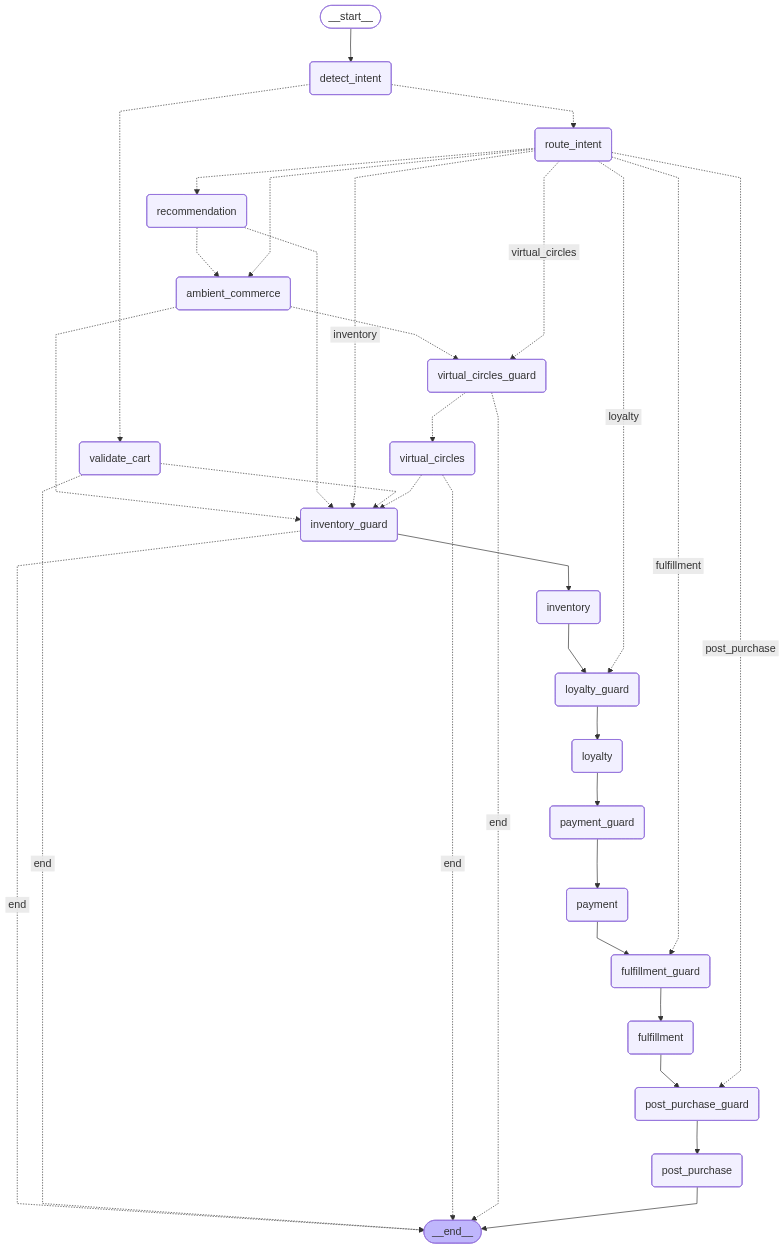

✓ PNG visualization successful — saved to artifacts\graph.png

RESULT: PNG visualization displayed.


In [153]:
# Paste this as ONE notebook cell to visualize your LangGraph workflow (PNG preferred, Mermaid fallback)
# Installs graphviz python binding if missing, attempts PNG render, then Mermaid text.
# No ASCII fallback; saves artifacts for debugging.

# Install graphviz python package if missing (quiet)

import graphviz

import os, platform, traceback
from pathlib import Path
from IPython.display import Image, display, Markdown

# Prepare artifact folder
Path("./artifacts").mkdir(exist_ok=True)

print("Sales Agent Workflow Graph Visualization")
print("=" * 80)

png_exc = None
mermaid_exc = None
png_saved = False
mermaid_saved = False

# Determine graph renderer object: prefer sales_graph, fallback to sales_workflow or 'graph' if present
graph_renderer = None
for candidate in ("sales_graph", "sales_workflow", "graph_built", "graph"):
    if candidate in globals():
        obj = globals()[candidate]
        # If it's a compiled graph with get_graph(), use that; else if it's a workflow, try .get_graph()
        if hasattr(obj, "get_graph"):
            graph_renderer = obj.get_graph()
            break
        # if object is a workflow builder with get_graph attribute, attempt
        try:
            graph_renderer = getattr(obj, "get_graph")()
            break
        except Exception:
            graph_renderer = None

if graph_renderer is None:
    # No LangGraph object found — instruct user and stop
    print("⚠ No LangGraph compiled graph found in notebook globals.")
    print("Make sure you have a compiled graph variable named 'sales_graph' or 'sales_workflow'.")
    print("Available globals:", [k for k in globals().keys() if k.isidentifier()][:200])
else:
    # Try PNG render first
    try:
        print("\n🎨 Attempting PNG visualization (preferred)...")
        png_bytes = None
        # Some implementations provide draw_mermaid_png directly on renderer, some on graph object — try both
        if hasattr(graph_renderer, "draw_mermaid_png"):
            png_bytes = graph_renderer.draw_mermaid_png()
        else:
            # try calling draw_mermaid_png on the higher-level compiled object
            if "sales_graph" in globals() and hasattr(globals()["sales_graph"], "get_graph"):
                png_bytes = globals()["sales_graph"].get_graph().draw_mermaid_png()
            elif "sales_workflow" in globals() and hasattr(globals()["sales_workflow"], "get_graph"):
                png_bytes = globals()["sales_workflow"].get_graph().draw_mermaid_png()

        if png_bytes:
            png_path = Path("./artifacts/graph.png")
            png_path.write_bytes(png_bytes)
            display(Image(png_bytes))
            print(f"✓ PNG visualization successful — saved to {png_path}")
            png_saved = True
        else:
            raise RuntimeError("draw_mermaid_png() returned empty payload or not available.")
    except Exception as e:
        png_exc = traceback.format_exc()
        print("⚠ PNG visualization failed (will try Mermaid).")
        # If likely Graphviz executable issue, print short install hints
        if "FileNotFoundError" in png_exc or "dot" in png_exc.lower():
            print("\nGraphviz executable seems missing. Install instructions:")
            os_type = platform.system()
            if os_type == "Windows":
                print("  • Windows: Download installer from https://graphviz.org/download/ and add to PATH, or `choco install graphviz`.")
            elif os_type == "Darwin":
                print("  • macOS: brew install graphviz")
            else:
                print("  • Linux: sudo apt-get install graphviz  (or use your distro package manager)")
        print("Full PNG error saved to ./artifacts/graph_png_error.txt")
        Path("./artifacts/graph_png_error.txt").write_text(png_exc)

    # Mermaid text fallback (if PNG not saved)
    if not png_saved:
        try:
            print("\n📋 Attempting Mermaid text visualization (fallback)...")
            mermaid_text = None
            # many LangGraph renderers expose draw_mermaid()
            if hasattr(graph_renderer, "draw_mermaid"):
                mermaid_text = graph_renderer.draw_mermaid()
            else:
                # try calling draw_mermaid on compiled object
                if "sales_graph" in globals() and hasattr(globals()["sales_graph"], "get_graph"):
                    mermaid_text = globals()["sales_graph"].get_graph().draw_mermaid()
                elif "sales_workflow" in globals() and hasattr(globals()["sales_workflow"], "get_graph"):
                    mermaid_text = globals()["sales_workflow"].get_graph().draw_mermaid()

            if mermaid_text:
                mermaid_path = Path("./artifacts/graph.mmd")
                mermaid_path.write_text(mermaid_text)
                display(Markdown(f"```mermaid\n{mermaid_text}\n```"))
                print(f"✓ Mermaid diagram rendered — saved to {mermaid_path}")
                mermaid_saved = True
            else:
                raise RuntimeError("draw_mermaid() returned empty payload or not available.")
        except Exception as e:
            mermaid_exc = traceback.format_exc()
            print("⚠ Mermaid generation failed. See ./artifacts/graph_mermaid_error.txt")
            Path("./artifacts/graph_mermaid_error.txt").write_text(mermaid_exc)

# Final status (no ASCII)
print("\n" + "=" * 80)
if png_saved:
    print("RESULT: PNG visualization displayed.")
elif mermaid_saved:
    print("RESULT: Mermaid diagram displayed (Mermaid text).")
else:
    print("RESULT: Visualization not available in this environment.")
    print(" • Check artifacts/graph_png_error.txt and artifacts/graph_mermaid_error.txt for details.")
    print(" • Ensure Graphviz (dot) is installed and in PATH for PNG rendering.")
print("=" * 80)


In [35]:
# CELL: Redis Session Example

print("Redis Session Persistence Example")
print("=" * 80)

# Simulate a multi-turn conversation
print("\n🔹 Turn 1: New session - searching for laptop")
result1 = run_graph_with_session("I'm looking for a laptop")
session_id = result1['session_token']

print(f"Session Token: {session_id}")
print(f"Intent: {result1['intent']}")
print(f"Response: {result1['worker_response'][:100]}...")
print(f"Session Persisted: {result1.get('session_persisted', False)}")

print("\n" + "─" * 80)
print("\n🔹 Turn 2: Resume session - check stock")
result2 = run_graph_with_session(
    "Do you have LAPTOP-001 in stock?",
    session_token=session_id
)

print(f"Session Token: {result2['session_token']}")
print(f"Intent: {result2['intent']}")
print(f"Response: {result2['worker_response'][:100]}...")
print(f"Session Persisted: {result2.get('session_persisted', False)}")

print("\n" + "─" * 80)
print("\n🔹 Turn 3: Resume session - checkout")
result3 = run_graph_with_session(
    "I want to checkout",
    session_token=session_id
)

print(f"Session Token: {result3['session_token']}")
print(f"Intent: {result3['intent']}")
print(f"Response: {result3['worker_response'][:150]}...")
print(f"Session Persisted: {result3.get('session_persisted', False)}")

print("\n" + "=" * 80)

# Verify session persistence
if redis_available:
    stored_session = load_session(session_id)
    if stored_session:
        print(f"\n✅ Session verified in Redis!")
        print(f"   Conversation History: {len(stored_session.get('conversation_history', []))} messages")
        print(f"   Cart Items: {len(stored_session.get('cart', []))}")
        print(f"   Updated At: {stored_session.get('updated_at', 'N/A')}")
    else:
        print("\n⚠ Session not found in Redis")
else:
    print(f"\n✅ Session stored in memory (Redis not available)")
    print(f"   In-memory sessions: {len(memory_sessions)}")

print("=" * 80)

2025-12-17 13:06:36,107 - __main__ - INFO - Generated new session token: session-20251217-130636-107536
2025-12-17 13:06:36,108 - __main__ - INFO - Session not found, creating new: session-20251217-130636-107536
2025-12-17 13:06:36,109 - __main__ - INFO - Session saved to Redis: session-20251217-130636-107536 (TTL: 3600s)
2025-12-17 13:06:36,109 - __main__ - INFO - New session created: session-20251217-130636-107536
2025-12-17 13:06:36,110 - __main__ - INFO - Processing message: 'I'm looking for a laptop...'
2025-12-17 13:06:36,110 - __main__ - ERROR - Error in graph execution: name 'sales_graph' is not defined
Traceback (most recent call last):
  File "/var/folders/ff/0mk5jk5x7jzdw6686n8qvv4r0000gn/T/ipykernel_5087/3749816290.py", line 48, in run_graph_with_session
    final_state = sales_graph.invoke(initial_state)
                  ^^^^^^^^^^^
NameError: name 'sales_graph' is not defined
2025-12-17 13:06:36,112 - __main__ - INFO - Session loaded from Redis: session-20251217-130636-1

Redis Session Persistence Example

🔹 Turn 1: New session - searching for laptop
Session Token: session-20251217-130636-107536
Intent: error
Response: Sorry, there was an error processing your request....
Session Persisted: False

────────────────────────────────────────────────────────────────────────────────

🔹 Turn 2: Resume session - check stock
Session Token: session-20251217-130636-107536
Intent: error
Response: Sorry, there was an error processing your request....
Session Persisted: False

────────────────────────────────────────────────────────────────────────────────

🔹 Turn 3: Resume session - checkout
Session Token: session-20251217-130636-107536
Intent: error
Response: Sorry, there was an error processing your request....
Session Persisted: False


✅ Session verified in Redis!
   Conversation History: 0 messages
   Cart Items: 0
   Updated At: 2025-12-17T13:06:36.109145


## Redis Session Example

Demonstrates session persistence across multiple messages.

## Test the Sales Agent

Run various test messages through the workflow.

In [36]:
# COMPREHENSIVE INTENT DETECTION TEST SUITE
# Tests all 6 intents and 3 recommendation modes with realistic Reebok products

print("=" * 80)
print("COMPREHENSIVE INTENT DETECTION TEST SUITE")
print("=" * 80)
print(f"\n✓ Testing with:")
print(f"  • Groq available: {groq_client is not None}")
print(f"  • Gemini available: {GEMINI_API_KEY is not None}")
print(f"  • 6 intents: {list(INTENT_CATEGORIES.keys())}")
print(f"  • 3 modes: normal, gifting_genius, trendseer")
print("\n" + "=" * 80)

# Test cases with expected results
test_cases = [
    # Recommendation - Normal Mode
    {"message": "Show me Reebok sports shoes for men under 3000 rupees", "expected_intent": "recommendation", "expected_mode": "normal"},
    {"message": "I need Reebok track pants for running", "expected_intent": "recommendation", "expected_mode": "normal"},
    {"message": "Dikhao ladies ke liye Reebok shoes", "expected_intent": "recommendation", "expected_mode": "normal"},
    
    # Recommendation - Gifting Genius Mode
    {"message": "I want to gift Reebok flip flops to my father for his birthday", "expected_intent": "recommendation", "expected_mode": "gifting_genius"},
    {"message": "What Reebok product would be good for my mother's anniversary?", "expected_intent": "recommendation", "expected_mode": "gifting_genius"},
    {"message": "Need a gift for my brother - he likes Reebok", "expected_intent": "recommendation", "expected_mode": "gifting_genius"},
    
    # Recommendation - Trendseer Mode
    {"message": "What's trending in Reebok footwear right now?", "expected_intent": "recommendation", "expected_mode": "trendseer"},
    {"message": "Show me the latest popular Reebok shoes", "expected_intent": "recommendation", "expected_mode": "trendseer"},
    {"message": "Which Reebok products are viral these days?", "expected_intent": "recommendation", "expected_mode": "trendseer"},
    
    # Inventory Intent
    {"message": "Do you have SKU000001 in stock?", "expected_intent": "inventory", "expected_mode": None},
    {"message": "Is the Reebok flip flop available?", "expected_intent": "inventory", "expected_mode": None},
    {"message": "Ye shoes milega kya?", "expected_intent": "inventory", "expected_mode": None},
    
    # Loyalty Intent
    {"message": "What discounts do you have on Reebok products?", "expected_intent": "loyalty", "expected_mode": None},
    {"message": "Can I get loyalty points for this purchase?", "expected_intent": "loyalty", "expected_mode": None},
    {"message": "Koi offer hai kya?", "expected_intent": "loyalty", "expected_mode": None},
    
    # Payment Intent
    {"message": "I want to checkout now", "expected_intent": "payment", "expected_mode": None},
    {"message": "How can I pay with UPI?", "expected_intent": "payment", "expected_mode": None},
    
    # Fulfillment Intent
    {"message": "When will my Reebok order arrive?", "expected_intent": "fulfillment", "expected_mode": None},
    {"message": "Track my delivery please", "expected_intent": "fulfillment", "expected_mode": None},
    
    # Post-Purchase Intent
    {"message": "I need to return SKU000032", "expected_intent": "post_purchase", "expected_mode": None},
    {"message": "Want to exchange my Reebok shoes", "expected_intent": "post_purchase", "expected_mode": None},
]

# Run tests
passed = 0
failed = 0
results = []

for i, test in enumerate(test_cases, 1):
    message = test["message"]
    expected_intent = test["expected_intent"]
    expected_mode = test["expected_mode"]
    
    # Call detection
    result = detect_intent(message, [])
    
    # Check if intent matches
    intent_match = result["intent"] == expected_intent
    mode_match = result.get("mode") == expected_mode if expected_mode is not None else True
    
    # Overall pass/fail
    test_passed = intent_match and mode_match
    
    if test_passed:
        passed += 1
        status = "✅ PASS"
    else:
        failed += 1
        status = "❌ FAIL"
    
    results.append({
        "test_num": i,
        "status": status,
        "message": message[:50] + "..." if len(message) > 50 else message,
        "expected_intent": expected_intent,
        "detected_intent": result["intent"],
        "expected_mode": expected_mode,
        "detected_mode": result.get("mode"),
        "confidence": result["confidence"],
        "method": result["method"],
        "explanation": result["explanation"],
        "entities": result["extracted_entities"]
    })

# Print results
for r in results:
    print(f"\n{r['status']} Test {r['test_num']}: {r['message']}")
    print(f"   Intent: {r['detected_intent']} (expected: {r['expected_intent']})")
    if r['expected_mode'] is not None:
        print(f"   Mode: {r['detected_mode']} (expected: {r['expected_mode']})")
    print(f"   Confidence: {r['confidence']:.2f} | Method: {r['method']}")
    print(f"   Explanation: {r['explanation'][:80]}")
    if r['entities']:
        print(f"   Entities: {r['entities']}")

# Print summary
print("\n" + "=" * 80)
print(f"TEST SUMMARY")
print("=" * 80)
print(f"Total: {len(test_cases)} | Passed: {passed} | Failed: {failed}")
print(f"Success Rate: {(passed/len(test_cases)*100):.1f}%")
print(f"\nSystem Status:")
print(f"  • Groq API: {'✓ Available' if groq_client else '✗ Not available'}")
print(f"  • Gemini API: {'✓ Available' if GEMINI_API_KEY else '✗ Not available'}")
print(f"  • Keyword Fallback: ✓ Always available")
print("=" * 80)

COMPREHENSIVE INTENT DETECTION TEST SUITE

✓ Testing with:
  • Groq available: True
  • Gemini available: True
  • 6 intents: ['recommendation', 'inventory', 'loyalty', 'payment', 'fulfillment', 'post_purchase']
  • 3 modes: normal, gifting_genius, trendseer



2025-12-17 13:06:40,300 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 13:06:40,303 - __main__ - INFO - ✓ Groq detected: recommendation (mode: normal, conf: 0.90)
2025-12-17 13:06:40,477 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 13:06:40,480 - __main__ - INFO - ✓ Groq detected: recommendation (mode: normal, conf: 0.90)
2025-12-17 13:06:40,689 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 13:06:40,692 - __main__ - INFO - ✓ Groq detected: recommendation (mode: normal, conf: 0.90)
2025-12-17 13:06:40,906 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 13:06:40,909 - __main__ - INFO - ✓ Groq detected: recommendation (mode: gifting_genius, conf: 0.90)
2025-12-17 13:06:41,223 - httpx - INFO - HTTP Request: POST https://api.groq


✅ PASS Test 1: Show me Reebok sports shoes for men under 3000 rup...
   Intent: recommendation (expected: recommendation)
   Mode: normal (expected: normal)
   Confidence: 0.90 | Method: groq
   Explanation: User is searching for specific product category with price filter
   Entities: {'budget_max': 3000, 'budget_min': 0, 'category': 'Footwear', 'occasion': 'sports', 'gender': 'male'}

✅ PASS Test 2: I need Reebok track pants for running
   Intent: recommendation (expected: recommendation)
   Mode: normal (expected: normal)
   Confidence: 0.90 | Method: groq
   Explanation: User is searching for a specific product
   Entities: {'category': 'Apparel', 'occasion': 'sports'}

✅ PASS Test 3: Dikhao ladies ke liye Reebok shoes
   Intent: recommendation (expected: recommendation)
   Mode: normal (expected: normal)
   Confidence: 0.90 | Method: groq
   Explanation: User is asking to show ladies' Reebok shoes
   Entities: {'category': 'Footwear', 'gender': 'female'}

✅ PASS Test 4: I want to

In [158]:
# CELL: TEST ORCHESTRATION FLOWS

print("=" * 80)
print("TESTING MULTI-STEP ORCHESTRATION FLOWS")
print("=" * 80)

test_scenarios = [
    {
        "name": "Flow 1: Recommendation → Inventory → Loyalty",
        "message": "Show me Reebok shoes for men under ₹3000",
        "expected_path": ["recommendation", "inventory", "loyalty"]
    },
    {
        "name": "Flow 2: Checkout (Payment) → Inventory → Loyalty → Payment → Fulfillment",
        "message": "I want to checkout now",
        "expected_path": ["inventory", "loyalty", "payment", "fulfillment"]
    },
    {
        "name": "Flow 3: Post-Purchase with Tracking",
        "message": "Track my order please",
        "expected_path": ["post_purchase", "fulfillment"]
    },
    {
        "name": "Flow 4: Trendseer (skips inventory)",
        "message": "What's trending in Reebok footwear?",
        "expected_path": ["recommendation"]
    }
]

for i, scenario in enumerate(test_scenarios, 1):
    print(f"\n{'─' * 80}")
    print(f"Test {i}: {scenario['name']}")
    print(f"{'─' * 80}")
    print(f"Message: \"{scenario['message']}\"")
    
    try:
        result = run_graph_with_session(scenario["message"])
        
        print(f"\n✓ Intent: {result['intent']}")
        print(f"✓ Confidence: {result['confidence']:.2f}")
        print(f"✓ Response: {result['worker_response'][:150]}...")
        
        # Check if orchestration worked
        metadata = result.get("metadata", {})
        last_worker = metadata.get("last_worker", "unknown")
        flow_path = metadata.get("flow_path", "normal")
        
        print(f"\n📊 Orchestration Details:")
        print(f"   Last Worker: {last_worker}")
        print(f"   Flow Path: {flow_path}")
        print(f"   Session Persisted: {result.get('session_persisted', False)}")
        
    except Exception as e:
        print(f"\n❌ Test failed: {str(e)}")

print("\n" + "=" * 80)
print("ORCHESTRATION TESTING COMPLETE")
print("=" * 80)

2025-12-17 03:41:27,885 - __main__ - INFO - Generated new session token: session-20251217-034127-885070
2025-12-17 03:41:27,898 - __main__ - INFO - Session not found, creating new: session-20251217-034127-885070
2025-12-17 03:41:27,910 - __main__ - INFO - Session saved to Redis: session-20251217-034127-885070 (TTL: 3600s)
2025-12-17 03:41:27,910 - __main__ - INFO - New session created: session-20251217-034127-885070
2025-12-17 03:41:27,910 - __main__ - INFO - Processing message: 'Show me Reebok shoes for men under ₹3000...'


TESTING MULTI-STEP ORCHESTRATION FLOWS

────────────────────────────────────────────────────────────────────────────────
Test 1: Flow 1: Recommendation → Inventory → Loyalty
────────────────────────────────────────────────────────────────────────────────
Message: "Show me Reebok shoes for men under ₹3000"


2025-12-17 03:41:28,368 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:41:28,371 - __main__ - INFO - ✓ Groq detected: recommendation (mode: normal, conf: 0.90)
2025-12-17 03:41:28,377 - __main__ - INFO - Intent detected: recommendation (mode: normal, conf: 0.90, method: groq)
2025-12-17 03:41:28,381 - __main__ - INFO - Recommendation node: 5 products found
2025-12-17 03:41:28,384 - __main__ - INFO - Using SKU from previous cards: LAPTOP-001
2025-12-17 03:41:28,384 - __main__ - INFO - Inventory node: SKU=LAPTOP-001, available=12
2025-12-17 03:41:28,387 - __main__ - INFO - Loyalty node: tier=Gold, discount=$195.0
2025-12-17 03:41:28,391 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-034128
2025-12-17 03:41:28,393 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-034128
2025-12-17 03:41:28,393 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-034128, action=support
2025-12


✓ Intent: recommendation
✓ Confidence: 0.90
✓ Response: Support Request Created:

Ticket ID: TICKET-20251217-034128
Type: Support
Status: Open
Priority: Medium

Support ticket created

Estimated Resolution:...

📊 Orchestration Details:
   Last Worker: post_purchase
   Flow Path: ['inventory', 'loyalty', 'payment', 'fulfillment', 'post_purchase']
   Session Persisted: True

────────────────────────────────────────────────────────────────────────────────
Test 2: Flow 2: Checkout (Payment) → Inventory → Loyalty → Payment → Fulfillment
────────────────────────────────────────────────────────────────────────────────
Message: "I want to checkout now"


2025-12-17 03:41:28,624 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:41:28,631 - __main__ - INFO - ✓ Groq detected: payment (mode: None, conf: 0.90)
2025-12-17 03:41:28,631 - __main__ - INFO - Intent detected: payment (mode: None, conf: 0.90, method: groq)
2025-12-17 03:41:28,631 - __main__ - INFO - Graph completed. Intent: payment
2025-12-17 03:41:28,644 - __main__ - INFO - Session saved to Redis: session-20251217-034128-409913 (TTL: 3600s)
2025-12-17 03:41:28,644 - __main__ - INFO - Generated new session token: session-20251217-034128-644312
2025-12-17 03:41:28,647 - __main__ - INFO - Session not found, creating new: session-20251217-034128-644312
2025-12-17 03:41:28,662 - __main__ - INFO - Session saved to Redis: session-20251217-034128-644312 (TTL: 3600s)
2025-12-17 03:41:28,662 - __main__ - INFO - New session created: session-20251217-034128-644312
2025-12-17 03:41:28,662 - __main__ - INFO - Processing message:


✓ Intent: payment
✓ Confidence: 0.90
✓ Response: Your cart is empty. Please add a product before checking out....

📊 Orchestration Details:
   Last Worker: validate_cart
   Flow Path: ['validate_cart']
   Session Persisted: True

────────────────────────────────────────────────────────────────────────────────
Test 3: Flow 3: Post-Purchase with Tracking
────────────────────────────────────────────────────────────────────────────────
Message: "Track my order please"


2025-12-17 03:41:28,848 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:41:28,848 - __main__ - INFO - ✓ Groq detected: fulfillment (mode: None, conf: 0.90)
2025-12-17 03:41:28,848 - __main__ - INFO - Intent detected: fulfillment (mode: None, conf: 0.90, method: groq)
2025-12-17 03:41:28,859 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-DEMO
2025-12-17 03:41:28,859 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-034128, action=support
2025-12-17 03:41:28,867 - __main__ - INFO - Graph completed. Intent: fulfillment
2025-12-17 03:41:28,877 - __main__ - INFO - Session saved to Redis: session-20251217-034128-644312 (TTL: 3600s)
2025-12-17 03:41:28,877 - __main__ - INFO - Generated new session token: session-20251217-034128-877843
2025-12-17 03:41:28,897 - __main__ - INFO - Session not found, creating new: session-20251217-034128-877843
2025-12-17 03:41:28,909 - __main__ - INFO - Session saved


✓ Intent: fulfillment
✓ Confidence: 0.90
✓ Response: Support Request Created:

Ticket ID: TICKET-20251217-034128
Type: Support
Status: Open
Priority: Medium

Support ticket created

Estimated Resolution:...

📊 Orchestration Details:
   Last Worker: post_purchase
   Flow Path: ['fulfillment', 'post_purchase']
   Session Persisted: True

────────────────────────────────────────────────────────────────────────────────
Test 4: Flow 4: Trendseer (skips inventory)
────────────────────────────────────────────────────────────────────────────────
Message: "What's trending in Reebok footwear?"


2025-12-17 03:41:29,144 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:41:29,158 - __main__ - INFO - ✓ Groq detected: recommendation (mode: trendseer, conf: 0.90)
2025-12-17 03:41:29,159 - __main__ - INFO - Intent detected: recommendation (mode: trendseer, conf: 0.90, method: groq)
2025-12-17 03:41:29,159 - __main__ - INFO - Recommendation node: 5 products found
2025-12-17 03:41:29,166 - __main__ - INFO - Using SKU from previous cards: LAPTOP-001
2025-12-17 03:41:29,166 - __main__ - INFO - Inventory node: SKU=LAPTOP-001, available=12
2025-12-17 03:41:29,169 - __main__ - INFO - Loyalty node: tier=Gold, discount=$195.0
2025-12-17 03:41:29,169 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-034129
2025-12-17 03:41:29,177 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-034129
2025-12-17 03:41:29,177 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-034129, action=support
2


✓ Intent: recommendation
✓ Confidence: 0.90
✓ Response: Support Request Created:

Ticket ID: TICKET-20251217-034129
Type: Support
Status: Open
Priority: Medium

Support ticket created

Estimated Resolution:...

📊 Orchestration Details:
   Last Worker: post_purchase
   Flow Path: ['inventory', 'loyalty', 'payment', 'fulfillment', 'post_purchase']
   Session Persisted: True

ORCHESTRATION TESTING COMPLETE


In [162]:
# --- TEST CELL: Orchestration End-to-End Test (FIXED: cart items include price) ---
from datetime import datetime

def make_test_state(**kwargs):
    """
    Helper to create a minimally valid SalesState for orchestration tests.
    """
    base = {
        'user_message': kwargs.get('user_message', 'Test message'),
        'conversation_history': kwargs.get('conversation_history', []),
        'detected_intent': kwargs.get('detected_intent', ''),
        'confidence': kwargs.get('confidence', 1.0),
        'cart': kwargs.get('cart', []),
        'user_id': kwargs.get('user_id', 'user_123'),
        'worker_response': kwargs.get('worker_response', ''),
        'cards': kwargs.get('cards', []),
        'metadata': kwargs.get('metadata', {}),
        'session_token': kwargs.get('session_token', 'test-session'),
        'timestamp': kwargs.get('timestamp', datetime.now().isoformat())
    }
    base.update(kwargs)
    return base

def run_orchestration_test(test_state):
    print("Input state:", test_state)
    result = sales_graph.invoke(test_state)
    print("Final state:", result)
    print("Worker response:", result.get('worker_response'))
    print("Error:", result.get('error'))
    print("---")
    return result

# Example test cases
# 1. Product discovery (recommendation intent, high confidence)
test_state_1 = make_test_state(
    user_message="Show me some shoes",
    detected_intent='recommendation',
    confidence=0.95,
    cart=[],
    metadata={}
)
run_orchestration_test(test_state_1)

# 2. Checkout flow (payment intent, cart present, payment success)
test_state_2 = make_test_state(
    user_message="I want to checkout",
    detected_intent='payment',
    confidence=0.9,
    cart=[{'sku': '123', 'qty': 1, 'price': 100.0}],
    metadata={'payment_status': 'success', 'order_id': 'ORD001'}
)
run_orchestration_test(test_state_2)

# 3. Low confidence triggers clarification (should not proceed)
test_state_3 = make_test_state(
    user_message="Maybe shoes?",
    detected_intent='recommendation',
    confidence=0.4,
    cart=[],
    metadata={}
)
run_orchestration_test(test_state_3)

# 4. Payment fails, fulfillment blocked
test_state_4 = make_test_state(
    user_message="Try to pay for my order",
    detected_intent='payment',
    confidence=0.8,
    cart=[{'sku': '456', 'qty': 2, 'price': 150.0}],
    metadata={'payment_status': 'failed'}
)
run_orchestration_test(test_state_4)

# 5. Post-purchase intent, order exists
test_state_5 = make_test_state(
    user_message="I want to return my order",
    detected_intent='post_purchase',
    confidence=0.85,
    cart=[],
    metadata={'order_id': 'ORD002', 'post_purchase_status': 'success'}
)
run_orchestration_test(test_state_5)


Input state: {'user_message': 'Show me some shoes', 'conversation_history': [], 'detected_intent': 'recommendation', 'confidence': 0.95, 'cart': [], 'user_id': 'user_123', 'worker_response': '', 'cards': [], 'metadata': {}, 'session_token': 'test-session', 'timestamp': '2025-12-17T03:48:21.250997'}


2025-12-17 03:48:21,713 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:48:21,713 - __main__ - INFO - ✓ Groq detected: recommendation (mode: normal, conf: 0.80)
2025-12-17 03:48:21,721 - __main__ - INFO - Intent detected: recommendation (mode: normal, conf: 0.80, method: groq)
2025-12-17 03:48:21,727 - __main__ - INFO - Recommendation node: 5 products found
2025-12-17 03:48:21,730 - __main__ - INFO - Using SKU from previous cards: LAPTOP-001
2025-12-17 03:48:21,730 - __main__ - INFO - Inventory node: SKU=LAPTOP-001, available=12
2025-12-17 03:48:21,732 - __main__ - INFO - Loyalty node: tier=Gold, discount=$195.0
2025-12-17 03:48:21,732 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-034821
2025-12-17 03:48:21,738 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-034821
2025-12-17 03:48:21,740 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-034821, action=support


Final state: {'user_message': 'Show me some shoes', 'conversation_history': [{'role': 'user', 'message': 'Show me some shoes', 'timestamp': '2025-12-17T03:48:21.721826', 'intent': 'recommendation', 'confidence': 0.8}], 'detected_intent': 'recommendation', 'confidence': 0.8, 'cart': [{'sku': 'LAPTOP-001', 'name': 'Dell XPS 15 Laptop', 'price': 1299.99, 'qty': 1}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-034821\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-034821', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'mode': 'normal', 'detection_method': 'groq', 'entities': {'category': 'Footwear'}, 'route_intent': 'recommendation', 'last_worker': 'post_purchase', 'flow_path': ['inventory', 'loyalty', 'payment', 'fulfillment', 'post_pu

2025-12-17 03:48:22,043 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:48:22,043 - __main__ - INFO - ✓ Groq detected: payment (mode: None, conf: 0.90)
2025-12-17 03:48:22,043 - __main__ - INFO - Intent detected: payment (mode: None, conf: 0.90, method: groq)
2025-12-17 03:48:22,050 - __main__ - INFO - Inventory node: SKU=None, available=N/A
2025-12-17 03:48:22,050 - __main__ - INFO - Loyalty node: tier=Gold, discount=$15.0
2025-12-17 03:48:22,057 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-034822
2025-12-17 03:48:22,059 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-034822
2025-12-17 03:48:22,059 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-034822, action=support


Final state: {'user_message': 'I want to checkout', 'conversation_history': [{'role': 'user', 'message': 'I want to checkout', 'timestamp': '2025-12-17T03:48:22.043951', 'intent': 'payment', 'confidence': 0.9}], 'detected_intent': 'payment', 'confidence': 0.9, 'cart': [{'sku': '123', 'qty': 1, 'price': 100.0}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-034822\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-034822', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'payment_status': 'success', 'order_id': 'ORD-20251217-034822', 'mode': None, 'detection_method': 'groq', 'entities': {}, 'flow_path': ['validate_cart', 'inventory', 'loyalty', 'payment', 'fulfillment', 'post_purchase'], 'last_worker': 'post_purchase', 'sku': '123', 'loyalty

2025-12-17 03:48:22,284 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:48:22,284 - __main__ - INFO - ✓ Groq detected: recommendation (mode: normal, conf: 0.80)
2025-12-17 03:48:22,289 - __main__ - INFO - Intent detected: recommendation (mode: normal, conf: 0.80, method: groq)
2025-12-17 03:48:22,292 - __main__ - INFO - Recommendation node: 5 products found
2025-12-17 03:48:22,294 - __main__ - INFO - Using SKU from previous cards: LAPTOP-001
2025-12-17 03:48:22,297 - __main__ - INFO - Inventory node: SKU=LAPTOP-001, available=12
2025-12-17 03:48:22,297 - __main__ - INFO - Loyalty node: tier=Gold, discount=$195.0
2025-12-17 03:48:22,302 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-034822
2025-12-17 03:48:22,307 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-034822
2025-12-17 03:48:22,309 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-034822, action=support


Final state: {'user_message': 'Maybe shoes?', 'conversation_history': [{'role': 'user', 'message': 'Maybe shoes?', 'timestamp': '2025-12-17T03:48:22.289343', 'intent': 'recommendation', 'confidence': 0.8}], 'detected_intent': 'recommendation', 'confidence': 0.8, 'cart': [{'sku': 'LAPTOP-001', 'name': 'Dell XPS 15 Laptop', 'price': 1299.99, 'qty': 1}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-034822\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-034822', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'mode': 'normal', 'detection_method': 'groq', 'entities': {'category': 'Footwear'}, 'route_intent': 'recommendation', 'last_worker': 'post_purchase', 'flow_path': ['inventory', 'loyalty', 'payment', 'fulfillment', 'post_purchase'], 's

2025-12-17 03:48:22,510 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:48:22,514 - __main__ - INFO - ✓ Groq detected: payment (mode: None, conf: 0.90)
2025-12-17 03:48:22,514 - __main__ - INFO - Intent detected: payment (mode: None, conf: 0.90, method: groq)
2025-12-17 03:48:22,514 - __main__ - INFO - Inventory node: SKU=None, available=N/A
2025-12-17 03:48:22,514 - __main__ - INFO - Loyalty node: tier=Gold, discount=$45.0
2025-12-17 03:48:22,522 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-034822
2025-12-17 03:48:22,522 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-034822
2025-12-17 03:48:22,522 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-034822, action=support


Final state: {'user_message': 'Try to pay for my order', 'conversation_history': [{'role': 'user', 'message': 'Try to pay for my order', 'timestamp': '2025-12-17T03:48:22.514920', 'intent': 'payment', 'confidence': 0.9}], 'detected_intent': 'payment', 'confidence': 0.9, 'cart': [{'sku': '456', 'qty': 2, 'price': 150.0}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-034822\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-034822', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'payment_status': 'failed', 'mode': None, 'detection_method': 'groq', 'entities': {}, 'flow_path': ['validate_cart', 'inventory', 'loyalty', 'payment', 'fulfillment', 'post_purchase'], 'last_worker': 'post_purchase', 'sku': '456', 'loyalty_applied': True, 'order_id

2025-12-17 03:48:22,735 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:48:22,735 - __main__ - INFO - ✓ Groq detected: post_purchase (mode: None, conf: 0.90)
2025-12-17 03:48:22,735 - __main__ - INFO - Intent detected: post_purchase (mode: None, conf: 0.90, method: groq)
2025-12-17 03:48:22,741 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-034822, action=return


Final state: {'user_message': 'I want to return my order', 'conversation_history': [{'role': 'user', 'message': 'I want to return my order', 'timestamp': '2025-12-17T03:48:22.735617', 'intent': 'post_purchase', 'confidence': 0.9}], 'detected_intent': 'post_purchase', 'confidence': 0.9, 'cart': [], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-034822\nType: Return\nStatus: Open\nPriority: Medium\n\nReturn initiated\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-034822', 'action': 'return', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'order_id': 'ORD002', 'post_purchase_status': 'success', 'mode': None, 'detection_method': 'groq', 'entities': {}, 'route_intent': 'post_purchase', 'flow_path': ['post_purchase'], 'last_worker': 'post_purchase'}, 'session_token': 'test-session', 'timestamp': '2025-12-17T03:48:22.735617'}
Worker r

{'user_message': 'I want to return my order',
 'conversation_history': [{'role': 'user',
   'message': 'I want to return my order',
   'timestamp': '2025-12-17T03:48:22.735617',
   'intent': 'post_purchase',
   'confidence': 0.9}],
 'detected_intent': 'post_purchase',
 'confidence': 0.9,
 'cart': [],
 'user_id': 'user_123',
 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-034822\nType: Return\nStatus: Open\nPriority: Medium\n\nReturn initiated\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.",
 'cards': [{'type': 'support_ticket',
   'ticket_id': 'TICKET-20251217-034822',
   'action': 'return',
   'status': 'Open',
   'priority': 'Medium'}],
 'metadata': {'order_id': 'ORD002',
  'post_purchase_status': 'success',
  'mode': None,
  'detection_method': 'groq',
  'entities': {},
  'route_intent': 'post_purchase',
  'flow_path': ['post_purchase'],
  'last_worker': 'post_purchase'},
 'session_token': 'test-session',
 'timestamp': '20

In [165]:
# --- ADDITIONAL TEST CELL: Orchestration Edge Cases & Worker Coverage ---
from datetime import datetime

def make_test_state(**kwargs):
    base = {
        'user_message': kwargs.get('user_message', 'Test message'),
        'conversation_history': kwargs.get('conversation_history', []),
        'detected_intent': kwargs.get('detected_intent', ''),
        'confidence': kwargs.get('confidence', 1.0),
        'cart': kwargs.get('cart', []),
        'user_id': kwargs.get('user_id', 'user_123'),
        'worker_response': kwargs.get('worker_response', ''),
        'cards': kwargs.get('cards', []),
        'metadata': kwargs.get('metadata', {}),
        'session_token': kwargs.get('session_token', 'test-session'),
        'timestamp': kwargs.get('timestamp', datetime.now().isoformat())
    }
    base.update(kwargs)
    return base

def run_orchestration_test(test_state, label=None):
    if label:
        print(f"\n=== {label} ===")
    print("Input state:", test_state)
    result = sales_graph.invoke(test_state)
    print("Final state:", result)
    print("Worker response:", result.get('worker_response'))
    print("Error:", result.get('error'))
    print("---")
    return result

# 6. Inventory direct (with SKU)
run_orchestration_test(
    make_test_state(
        user_message="Is SKU 999 in stock?",
        detected_intent='inventory',
        cart=[{'sku': '999', 'qty': 1, 'price': 50.0}],
        metadata={}
    ),
    label="Inventory Direct (with SKU)"
)

# 7. Inventory direct (missing SKU)
run_orchestration_test(
    make_test_state(
        user_message="Is this available?",
        detected_intent='inventory',
        cart=[{'qty': 1, 'price': 50.0}],
        metadata={}
    ),
    label="Inventory Direct (missing SKU)"
)

# 8. Loyalty direct
run_orchestration_test(
    make_test_state(
        user_message="Any discounts?",
        detected_intent='loyalty',
        cart=[{'sku': '888', 'qty': 2, 'price': 75.0}],
        metadata={}
    ),
    label="Loyalty Direct"
)

# 9. Fulfillment direct
run_orchestration_test(
    make_test_state(
        user_message="When will my order arrive?",
        detected_intent='fulfillment',
        metadata={'order_id': 'ORD777'}
    ),
    label="Fulfillment Direct"
)

# 10. Post-purchase (no order id)
run_orchestration_test(
    make_test_state(
        user_message="I want to return something",
        detected_intent='post_purchase',
        metadata={}
    ),
    label="Post-Purchase (No Order ID)"
)

# 11. Virtual Circles (allowed intent)
run_orchestration_test(
    make_test_state(
        user_message="What's trending with my friends?",
        detected_intent='recommendation',
        metadata={}
    ),
    label="Virtual Circles (Allowed)"
)

# 12. Virtual Circles (blocked intent)
run_orchestration_test(
    make_test_state(
        user_message="Try virtual circles for payment",
        detected_intent='payment',
        metadata={}
    ),
    label="Virtual Circles (Blocked)"
)

# 13. Ambient Commerce (visual search)
run_orchestration_test(
    make_test_state(
        user_message="Find products from this image",
        detected_intent='recommendation',
        metadata={'visual_search': True}
    ),
    label="Ambient Commerce (Visual Search)"
)



=== Inventory Direct (with SKU) ===
Input state: {'user_message': 'Is SKU 999 in stock?', 'conversation_history': [], 'detected_intent': 'inventory', 'confidence': 1.0, 'cart': [{'sku': '999', 'qty': 1, 'price': 50.0}], 'user_id': 'user_123', 'worker_response': '', 'cards': [], 'metadata': {}, 'session_token': 'test-session', 'timestamp': '2025-12-17T03:50:31.395206'}


2025-12-17 03:50:31,599 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:50:31,599 - __main__ - INFO - ✓ Groq detected: inventory (mode: None, conf: 0.90)
2025-12-17 03:50:31,613 - __main__ - INFO - Intent detected: inventory (mode: None, conf: 0.90, method: groq)
2025-12-17 03:50:31,615 - __main__ - INFO - Inventory node: SKU=None, available=N/A
2025-12-17 03:50:31,615 - __main__ - INFO - Loyalty node: tier=Gold, discount=$7.5
2025-12-17 03:50:31,621 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-035031
2025-12-17 03:50:31,621 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-035031
2025-12-17 03:50:31,621 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-035031, action=support
2025-12-17 03:50:31,779 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:50:31,779 - __main__ - INFO - ✓ Groq detected: inventory

Final state: {'user_message': 'Is SKU 999 in stock?', 'conversation_history': [{'role': 'user', 'message': 'Is SKU 999 in stock?', 'timestamp': '2025-12-17T03:50:31.613481', 'intent': 'inventory', 'confidence': 0.9}], 'detected_intent': 'inventory', 'confidence': 0.9, 'cart': [{'sku': '999', 'qty': 1, 'price': 50.0}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-035031\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-035031', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'mode': None, 'detection_method': 'groq', 'entities': {}, 'route_intent': 'inventory', 'flow_path': ['inventory', 'loyalty', 'payment', 'fulfillment', 'post_purchase'], 'last_worker': 'post_purchase', 'sku': '999', 'loyalty_applied': True, 'order_id': 'ORD-20251217-03

2025-12-17 03:50:31,976 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:50:31,982 - __main__ - INFO - ✓ Groq detected: loyalty (mode: None, conf: 0.90)
2025-12-17 03:50:31,982 - __main__ - INFO - Intent detected: loyalty (mode: None, conf: 0.90, method: groq)
2025-12-17 03:50:31,986 - __main__ - INFO - Loyalty node: tier=Gold, discount=$22.5
2025-12-17 03:50:31,986 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-035031
2025-12-17 03:50:31,992 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-035031
2025-12-17 03:50:31,992 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-035031, action=support


Final state: {'user_message': 'Any discounts?', 'conversation_history': [{'role': 'user', 'message': 'Any discounts?', 'timestamp': '2025-12-17T03:50:31.982092', 'intent': 'loyalty', 'confidence': 0.9}], 'detected_intent': 'loyalty', 'confidence': 0.9, 'cart': [{'sku': '888', 'qty': 2, 'price': 75.0}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-035031\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-035031', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'mode': None, 'detection_method': 'groq', 'entities': {}, 'route_intent': 'loyalty', 'flow_path': ['loyalty', 'payment', 'fulfillment', 'post_purchase'], 'last_worker': 'post_purchase', 'loyalty_applied': True, 'order_id': 'ORD-20251217-035031'}, 'session_token': 'test-session', 'tim

2025-12-17 03:50:32,280 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:50:32,280 - __main__ - INFO - ✓ Groq detected: fulfillment (mode: None, conf: 0.90)
2025-12-17 03:50:32,288 - __main__ - INFO - Intent detected: fulfillment (mode: None, conf: 0.90, method: groq)
2025-12-17 03:50:32,290 - __main__ - INFO - Fulfillment node: order_id=ORD777
2025-12-17 03:50:32,290 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-035032, action=support


Final state: {'user_message': 'When will my order arrive?', 'conversation_history': [{'role': 'user', 'message': 'When will my order arrive?', 'timestamp': '2025-12-17T03:50:32.288855', 'intent': 'fulfillment', 'confidence': 0.9}], 'detected_intent': 'fulfillment', 'confidence': 0.9, 'cart': [], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-035032\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-035032', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'order_id': 'ORD777', 'mode': None, 'detection_method': 'groq', 'entities': {}, 'route_intent': 'fulfillment', 'flow_path': ['fulfillment', 'post_purchase'], 'last_worker': 'post_purchase'}, 'session_token': 'test-session', 'timestamp': '2025-12-17T03:50:32.288855'}
Worker response: Support

2025-12-17 03:50:32,481 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:50:32,486 - __main__ - INFO - ✓ Groq detected: post_purchase (mode: None, conf: 0.90)
2025-12-17 03:50:32,486 - __main__ - INFO - Intent detected: post_purchase (mode: None, conf: 0.90, method: groq)
2025-12-17 03:50:32,491 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-035032, action=return
2025-12-17 03:50:32,654 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:50:32,654 - __main__ - INFO - ✓ Groq detected: recommendation (mode: trendseer, conf: 0.80)
2025-12-17 03:50:32,654 - __main__ - INFO - Intent detected: recommendation (mode: trendseer, conf: 0.80, method: groq)
2025-12-17 03:50:32,654 - __main__ - INFO - Recommendation node: 5 products found
2025-12-17 03:50:32,654 - __main__ - INFO - Using SKU from previous cards: LAPTOP-001
2025-12-17 03:50:32,654 - __

Final state: {'user_message': 'I want to return something', 'conversation_history': [{'role': 'user', 'message': 'I want to return something', 'timestamp': '2025-12-17T03:50:32.486600', 'intent': 'post_purchase', 'confidence': 0.9}], 'detected_intent': 'post_purchase', 'confidence': 0.9, 'cart': [], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-035032\nType: Return\nStatus: Open\nPriority: Medium\n\nReturn initiated\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-035032', 'action': 'return', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'mode': None, 'detection_method': 'groq', 'entities': {}, 'route_intent': 'post_purchase', 'flow_path': ['post_purchase'], 'last_worker': 'post_purchase'}, 'session_token': 'test-session', 'timestamp': '2025-12-17T03:50:32.486600'}
Worker response: Support Request Created:

Ticket ID: TICKET-20

2025-12-17 03:50:32,859 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:50:32,867 - __main__ - INFO - ✓ Groq detected: payment (mode: None, conf: 0.80)
2025-12-17 03:50:32,867 - __main__ - INFO - Intent detected: payment (mode: None, conf: 0.80, method: groq)


Final state: {'user_message': 'Try virtual circles for payment', 'conversation_history': [{'role': 'user', 'message': 'Try virtual circles for payment', 'timestamp': '2025-12-17T03:50:32.867237', 'intent': 'payment', 'confidence': 0.8}], 'detected_intent': 'payment', 'confidence': 0.8, 'cart': [], 'user_id': 'user_123', 'worker_response': 'Your cart is empty. Please add a product before checking out.', 'cards': [], 'metadata': {'mode': None, 'detection_method': 'groq', 'entities': {'gender': 'male'}, 'flow_path': ['validate_cart'], 'last_worker': 'validate_cart'}, 'session_token': 'test-session', 'timestamp': '2025-12-17T03:50:32.867237'}
Worker response: Your cart is empty. Please add a product before checking out.
Error: None
---

=== Ambient Commerce (Visual Search) ===
Input state: {'user_message': 'Find products from this image', 'conversation_history': [], 'detected_intent': 'recommendation', 'confidence': 1.0, 'cart': [], 'user_id': 'user_123', 'worker_response': '', 'cards': []

2025-12-17 03:50:33,080 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 03:50:33,080 - __main__ - INFO - ✓ Groq detected: recommendation (mode: None, conf: 0.80)
2025-12-17 03:50:33,080 - __main__ - INFO - Intent detected: recommendation (mode: None, conf: 0.80, method: groq)
2025-12-17 03:50:33,089 - __main__ - INFO - Recommendation node: 5 products found
2025-12-17 03:50:33,098 - __main__ - INFO - Using SKU from previous cards: LAPTOP-001
2025-12-17 03:50:33,098 - __main__ - INFO - Inventory node: SKU=LAPTOP-001, available=12
2025-12-17 03:50:33,098 - __main__ - INFO - Loyalty node: tier=Gold, discount=$195.0
2025-12-17 03:50:33,098 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-035033
2025-12-17 03:50:33,106 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-035033
2025-12-17 03:50:33,106 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-035033, action=support


Final state: {'user_message': 'Find products from this image', 'conversation_history': [{'role': 'user', 'message': 'Find products from this image', 'timestamp': '2025-12-17T03:50:33.080047', 'intent': 'recommendation', 'confidence': 0.8}], 'detected_intent': 'recommendation', 'confidence': 0.8, 'cart': [{'sku': 'LAPTOP-001', 'name': 'Dell XPS 15 Laptop', 'price': 1299.99, 'qty': 1}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-035033\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-035033', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'visual_search': True, 'mode': None, 'detection_method': 'groq', 'entities': {}, 'route_intent': 'recommendation', 'last_worker': 'post_purchase', 'flow_path': ['inventory', 'loyalty', 'payment', 'ful

{'user_message': 'Find products from this image',
 'conversation_history': [{'role': 'user',
   'message': 'Find products from this image',
   'timestamp': '2025-12-17T03:50:33.080047',
   'intent': 'recommendation',
   'confidence': 0.8}],
 'detected_intent': 'recommendation',
 'confidence': 0.8,
 'cart': [{'sku': 'LAPTOP-001',
   'name': 'Dell XPS 15 Laptop',
   'price': 1299.99,
   'qty': 1}],
 'user_id': 'user_123',
 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-035033\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.",
 'cards': [{'type': 'support_ticket',
   'ticket_id': 'TICKET-20251217-035033',
   'action': 'support',
   'status': 'Open',
   'priority': 'Medium'}],
 'metadata': {'visual_search': True,
  'mode': None,
  'detection_method': 'groq',
  'entities': {},
  'route_intent': 'recommendation',
  'last_worker': 'post_purchase',
  'flow_path': 

In [167]:
# --- TEST CELL: HAPPY PATH & EDGE SCENARIOS ---
from datetime import datetime

def make_test_state(**kwargs):
    base = {
        'user_message': kwargs.get('user_message', 'Test message'),
        'conversation_history': kwargs.get('conversation_history', []),
        'detected_intent': kwargs.get('detected_intent', ''),
        'confidence': kwargs.get('confidence', 1.0),
        'cart': kwargs.get('cart', []),
        'user_id': kwargs.get('user_id', 'user_123'),
        'worker_response': kwargs.get('worker_response', ''),
        'cards': kwargs.get('cards', []),
        'metadata': kwargs.get('metadata', {}),
        'session_token': kwargs.get('session_token', 'test-session'),
        'timestamp': kwargs.get('timestamp', datetime.now().isoformat())
    }
    base.update(kwargs)
    return base

def run_orchestration_test(test_state, label=None):
    if label:
        print(f"\n=== {label} ===")
    result = sales_graph.invoke(test_state)
    print("Detected intent:", result.get('detected_intent'))
    print("Final state:", result)
    print("Worker response:", result.get('worker_response'))
    print("Error:", result.get('error'))
    print("Flow path:", result.get('metadata', {}).get('flow_path'))
    print("---")
    return result

# 1. Product Discovery
run_orchestration_test(
    make_test_state(
        user_message="Recommend running shoes for men under ₹5000",
        detected_intent='recommendation',
        cart=[],
        metadata={}
    ),
    label="Product Discovery"
)

# 2. Trend / Social Discovery
run_orchestration_test(
    make_test_state(
        user_message="What are people like me buying?",
        detected_intent='recommendation',
        cart=[],
        metadata={}
    ),
    label="Trend / Social Discovery"
)

# 3. Visual Search
run_orchestration_test(
    make_test_state(
        user_message="Find something similar to this",
        detected_intent='recommendation',
        cart=[],
        metadata={'visual_search': True}
    ),
    label="Visual Search"
)

# 4. Add to Cart + Checkout
run_orchestration_test(
    make_test_state(
        user_message="Add this to cart and checkout",
        detected_intent='payment',
        cart=[{'sku': 'A1', 'qty': 1, 'price': 2000.0}],
        metadata={'payment_status': 'success', 'order_id': 'ORD100'}
    ),
    label="Add to Cart + Checkout"
)

# 5. Order Tracking
run_orchestration_test(
    make_test_state(
        user_message="Where is my order?",
        detected_intent='fulfillment',
        metadata={'order_id': 'ORD200'}
    ),
    label="Order Tracking"
)

# 6. Return Request
run_orchestration_test(
    make_test_state(
        user_message="I want to return my order",
        detected_intent='post_purchase',
        metadata={'order_id': 'ORD300', 'post_purchase_status': 'success'}
    ),
    label="Return Request"
)

# 7. Checkout With Empty Cart
run_orchestration_test(
    make_test_state(
        user_message="Checkout",
        detected_intent='payment',
        cart=[],
        metadata={}
    ),
    label="Checkout With Empty Cart"
)

# 8. Inventory Out of Stock
run_orchestration_test(
    make_test_state(
        user_message="Buy this shoe",
        detected_intent='inventory',
        cart=[{'sku': 'OOS1', 'qty': 1, 'price': 3000.0}],
        metadata={'inventory_status': 'out_of_stock'}
    ),
    label="Inventory Out of Stock"
)

# 9. Payment Failure
run_orchestration_test(
    make_test_state(
        user_message="Pay now",
        detected_intent='payment',
        cart=[{'sku': 'A2', 'qty': 1, 'price': 2500.0}],
        metadata={'payment_status': 'failed'}
    ),
    label="Payment Failure"
)

# 10. Duplicate Checkout Click
run_orchestration_test(
    make_test_state(
        user_message="Pay",
        detected_intent='payment',
        cart=[{'sku': 'A2', 'qty': 1, 'price': 2500.0}],
        metadata={'payment_status': 'success', 'order_id': 'ORD400', 'idempotency_key': 'pay-dup'}
    ),
    label="Duplicate Checkout Click"
)

# 11. Ambiguous Request
run_orchestration_test(
    make_test_state(
        user_message="I need help",
        detected_intent='',
        cart=[],
        metadata={}
    ),
    label="Ambiguous Request"
)

# 12. Wrong Order ID
run_orchestration_test(
    make_test_state(
        user_message="Track order ORD99999",
        detected_intent='fulfillment',
        metadata={'order_id': 'ORD99999'}
    ),
    label="Wrong Order ID"
)



=== Product Discovery ===


2025-12-17 04:15:51,607 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 04:15:51,607 - __main__ - INFO - ✓ Groq detected: recommendation (mode: normal, conf: 0.90)
2025-12-17 04:15:51,607 - __main__ - INFO - Intent detected: recommendation (mode: normal, conf: 0.90, method: groq)
2025-12-17 04:15:51,607 - __main__ - INFO - Recommendation node: 5 products found
2025-12-17 04:15:51,607 - __main__ - INFO - Using SKU from previous cards: LAPTOP-001
2025-12-17 04:15:51,607 - __main__ - INFO - Inventory node: SKU=LAPTOP-001, available=12
2025-12-17 04:15:51,607 - __main__ - INFO - Loyalty node: tier=Gold, discount=$195.0
2025-12-17 04:15:51,624 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-041551
2025-12-17 04:15:51,627 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-041551
2025-12-17 04:15:51,629 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-041551, action=support


Detected intent: recommendation
Final state: {'user_message': 'Recommend running shoes for men under ₹5000', 'conversation_history': [{'role': 'user', 'message': 'Recommend running shoes for men under ₹5000', 'timestamp': '2025-12-17T04:15:51.607732', 'intent': 'recommendation', 'confidence': 0.9}], 'detected_intent': 'recommendation', 'confidence': 0.9, 'cart': [{'sku': 'LAPTOP-001', 'name': 'Dell XPS 15 Laptop', 'price': 1299.99, 'qty': 1}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-041551\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-041551', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'mode': 'normal', 'detection_method': 'groq', 'entities': {'budget_max': 5000, 'budget_min': 0, 'category': 'Footwear', 'occasion': 'sports'

2025-12-17 04:15:51,848 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 04:15:52,007 - __main__ - INFO - ✓ Groq detected: recommendation (mode: trendseer, conf: 0.80)
2025-12-17 04:15:52,007 - __main__ - INFO - Intent detected: recommendation (mode: trendseer, conf: 0.80, method: groq)
2025-12-17 04:15:52,007 - __main__ - INFO - Recommendation node: 5 products found
2025-12-17 04:15:52,007 - __main__ - INFO - Using SKU from previous cards: LAPTOP-001
2025-12-17 04:15:52,007 - __main__ - INFO - Inventory node: SKU=LAPTOP-001, available=12
2025-12-17 04:15:52,007 - __main__ - INFO - Loyalty node: tier=Gold, discount=$195.0
2025-12-17 04:15:52,007 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-041552
2025-12-17 04:15:52,023 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-041552
2025-12-17 04:15:52,025 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-041552, action=support
2

Detected intent: recommendation
Final state: {'user_message': 'What are people like me buying?', 'conversation_history': [{'role': 'user', 'message': 'What are people like me buying?', 'timestamp': '2025-12-17T04:15:52.007670', 'intent': 'recommendation', 'confidence': 0.8}], 'detected_intent': 'recommendation', 'confidence': 0.8, 'cart': [{'sku': 'LAPTOP-001', 'name': 'Dell XPS 15 Laptop', 'price': 1299.99, 'qty': 1}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-041552\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-041552', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'mode': 'trendseer', 'detection_method': 'groq', 'entities': {'category': 'Accessories'}, 'route_intent': 'recommendation', 'last_worker': 'post_purchase', 'flow_pa

2025-12-17 04:15:52,268 - __main__ - INFO - ✓ Groq detected: recommendation (mode: normal, conf: 0.80)
2025-12-17 04:15:52,268 - __main__ - INFO - Intent detected: recommendation (mode: normal, conf: 0.80, method: groq)
2025-12-17 04:15:52,274 - __main__ - INFO - Recommendation node: 5 products found
2025-12-17 04:15:52,277 - __main__ - INFO - Using SKU from previous cards: LAPTOP-001
2025-12-17 04:15:52,278 - __main__ - INFO - Inventory node: SKU=LAPTOP-001, available=12
2025-12-17 04:15:52,280 - __main__ - INFO - Loyalty node: tier=Gold, discount=$195.0
2025-12-17 04:15:52,282 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-041552
2025-12-17 04:15:52,283 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-041552
2025-12-17 04:15:52,285 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-041552, action=support


Detected intent: recommendation
Final state: {'user_message': 'Find something similar to this', 'conversation_history': [{'role': 'user', 'message': 'Find something similar to this', 'timestamp': '2025-12-17T04:15:52.268920', 'intent': 'recommendation', 'confidence': 0.8}], 'detected_intent': 'recommendation', 'confidence': 0.8, 'cart': [{'sku': 'LAPTOP-001', 'name': 'Dell XPS 15 Laptop', 'price': 1299.99, 'qty': 1}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-041552\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-041552', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'visual_search': True, 'mode': 'normal', 'detection_method': 'groq', 'entities': {}, 'route_intent': 'recommendation', 'last_worker': 'post_purchase', 'flow_path': ['

2025-12-17 04:15:52,674 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 04:15:52,674 - __main__ - INFO - ✓ Groq detected: payment (mode: None, conf: 0.90)
2025-12-17 04:15:52,674 - __main__ - INFO - Intent detected: payment (mode: None, conf: 0.90, method: groq)
2025-12-17 04:15:52,674 - __main__ - INFO - Inventory node: SKU=None, available=N/A
2025-12-17 04:15:52,684 - __main__ - INFO - Loyalty node: tier=Gold, discount=$300.0
2025-12-17 04:15:52,684 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-041552
2025-12-17 04:15:52,684 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-041552
2025-12-17 04:15:52,684 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-041552, action=support


Detected intent: payment
Final state: {'user_message': 'Add this to cart and checkout', 'conversation_history': [{'role': 'user', 'message': 'Add this to cart and checkout', 'timestamp': '2025-12-17T04:15:52.674227', 'intent': 'payment', 'confidence': 0.9}], 'detected_intent': 'payment', 'confidence': 0.9, 'cart': [{'sku': 'A1', 'qty': 1, 'price': 2000.0}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-041552\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-041552', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'payment_status': 'success', 'order_id': 'ORD-20251217-041552', 'mode': None, 'detection_method': 'groq', 'entities': {}, 'flow_path': ['validate_cart', 'inventory', 'loyalty', 'payment', 'fulfillment', 'post_purchase'], 'last_w

2025-12-17 04:15:52,890 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 04:15:52,891 - __main__ - INFO - ✓ Groq detected: fulfillment (mode: None, conf: 0.90)
2025-12-17 04:15:52,892 - __main__ - INFO - Intent detected: fulfillment (mode: None, conf: 0.90, method: groq)
2025-12-17 04:15:52,893 - __main__ - INFO - Fulfillment node: order_id=ORD200
2025-12-17 04:15:52,895 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-041552, action=support


Detected intent: fulfillment
Final state: {'user_message': 'Where is my order?', 'conversation_history': [{'role': 'user', 'message': 'Where is my order?', 'timestamp': '2025-12-17T04:15:52.892289', 'intent': 'fulfillment', 'confidence': 0.9}], 'detected_intent': 'fulfillment', 'confidence': 0.9, 'cart': [], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-041552\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-041552', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'order_id': 'ORD200', 'mode': None, 'detection_method': 'groq', 'entities': {}, 'route_intent': 'fulfillment', 'flow_path': ['fulfillment', 'post_purchase'], 'last_worker': 'post_purchase'}, 'session_token': 'test-session', 'timestamp': '2025-12-17T04:15:52.892289'}
Worker resp

2025-12-17 04:15:53,205 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 04:15:53,211 - __main__ - INFO - ✓ Groq detected: post_purchase (mode: None, conf: 0.90)
2025-12-17 04:15:53,212 - __main__ - INFO - Intent detected: post_purchase (mode: None, conf: 0.90, method: groq)
2025-12-17 04:15:53,213 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-041553, action=return
2025-12-17 04:15:53,394 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 04:15:53,394 - __main__ - INFO - ✓ Groq detected: payment (mode: None, conf: 0.90)
2025-12-17 04:15:53,394 - __main__ - INFO - Intent detected: payment (mode: None, conf: 0.90, method: groq)


Detected intent: post_purchase
Final state: {'user_message': 'I want to return my order', 'conversation_history': [{'role': 'user', 'message': 'I want to return my order', 'timestamp': '2025-12-17T04:15:53.212032', 'intent': 'post_purchase', 'confidence': 0.9}], 'detected_intent': 'post_purchase', 'confidence': 0.9, 'cart': [], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-041553\nType: Return\nStatus: Open\nPriority: Medium\n\nReturn initiated\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-041553', 'action': 'return', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'order_id': 'ORD300', 'post_purchase_status': 'success', 'mode': None, 'detection_method': 'groq', 'entities': {}, 'route_intent': 'post_purchase', 'flow_path': ['post_purchase'], 'last_worker': 'post_purchase'}, 'session_token': 'test-session', 'timestamp': '2025-1

2025-12-17 04:15:53,641 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 04:15:53,646 - __main__ - INFO - ✓ Groq detected: recommendation (mode: None, conf: 0.80)
2025-12-17 04:15:53,647 - __main__ - INFO - Intent detected: recommendation (mode: None, conf: 0.80, method: groq)
2025-12-17 04:15:53,649 - __main__ - INFO - Recommendation node: 5 products found
2025-12-17 04:15:53,650 - __main__ - INFO - Using SKU from previous cards: LAPTOP-001
2025-12-17 04:15:53,650 - __main__ - INFO - Inventory node: SKU=LAPTOP-001, available=12
2025-12-17 04:15:53,651 - __main__ - INFO - Loyalty node: tier=Gold, discount=$450.0
2025-12-17 04:15:53,652 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-041553
2025-12-17 04:15:53,653 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-041553
2025-12-17 04:15:53,655 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-041553, action=support


Detected intent: recommendation
Final state: {'user_message': 'Buy this shoe', 'conversation_history': [{'role': 'user', 'message': 'Buy this shoe', 'timestamp': '2025-12-17T04:15:53.647715', 'intent': 'recommendation', 'confidence': 0.8}], 'detected_intent': 'recommendation', 'confidence': 0.8, 'cart': [{'sku': 'OOS1', 'qty': 1, 'price': 3000.0}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-041553\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-041553', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'inventory_status': 'out_of_stock', 'mode': None, 'detection_method': 'groq', 'entities': {'category': 'Footwear'}, 'route_intent': 'recommendation', 'last_worker': 'post_purchase', 'flow_path': ['inventory', 'loyalty', 'payment', 'fulfi

2025-12-17 04:15:53,850 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 04:15:53,850 - __main__ - INFO - ✓ Groq detected: payment (mode: None, conf: 0.90)
2025-12-17 04:15:53,850 - __main__ - INFO - Intent detected: payment (mode: None, conf: 0.90, method: groq)
2025-12-17 04:15:53,856 - __main__ - INFO - Inventory node: SKU=None, available=N/A
2025-12-17 04:15:53,857 - __main__ - INFO - Loyalty node: tier=Gold, discount=$375.0
2025-12-17 04:15:53,857 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-041553
2025-12-17 04:15:53,857 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-041553
2025-12-17 04:15:53,864 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-041553, action=support


Detected intent: payment
Final state: {'user_message': 'Pay now', 'conversation_history': [{'role': 'user', 'message': 'Pay now', 'timestamp': '2025-12-17T04:15:53.850344', 'intent': 'payment', 'confidence': 0.9}], 'detected_intent': 'payment', 'confidence': 0.9, 'cart': [{'sku': 'A2', 'qty': 1, 'price': 2500.0}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-041553\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-041553', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'payment_status': 'failed', 'mode': None, 'detection_method': 'groq', 'entities': {}, 'flow_path': ['validate_cart', 'inventory', 'loyalty', 'payment', 'fulfillment', 'post_purchase'], 'last_worker': 'post_purchase', 'sku': 'A2', 'loyalty_applied': True, 'order_id': 'ORD-

2025-12-17 04:15:54,175 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 04:15:54,177 - __main__ - INFO - ✓ Groq detected: payment (mode: None, conf: 0.90)
2025-12-17 04:15:54,178 - __main__ - INFO - Intent detected: payment (mode: None, conf: 0.90, method: groq)
2025-12-17 04:15:54,179 - __main__ - INFO - Inventory node: SKU=None, available=N/A
2025-12-17 04:15:54,180 - __main__ - INFO - Loyalty node: tier=Gold, discount=$375.0
2025-12-17 04:15:54,181 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-041554
2025-12-17 04:15:54,182 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-041554
2025-12-17 04:15:54,183 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-041554, action=support


Detected intent: payment
Final state: {'user_message': 'Pay', 'conversation_history': [{'role': 'user', 'message': 'Pay', 'timestamp': '2025-12-17T04:15:54.178635', 'intent': 'payment', 'confidence': 0.9}], 'detected_intent': 'payment', 'confidence': 0.9, 'cart': [{'sku': 'A2', 'qty': 1, 'price': 2500.0}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-041554\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-041554', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'payment_status': 'success', 'order_id': 'ORD-20251217-041554', 'idempotency_key': 'pay-dup', 'mode': None, 'detection_method': 'groq', 'entities': {}, 'flow_path': ['validate_cart', 'inventory', 'loyalty', 'payment', 'fulfillment', 'post_purchase'], 'last_worker': 'post_purchase

2025-12-17 04:15:54,388 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 04:15:54,396 - __main__ - INFO - ✓ Groq detected: recommendation (mode: None, conf: 0.50)
2025-12-17 04:15:54,399 - __main__ - INFO - Intent detected: recommendation (mode: None, conf: 0.50, method: groq)
2025-12-17 04:15:54,401 - __main__ - INFO - Recommendation node: 5 products found
2025-12-17 04:15:54,403 - __main__ - INFO - Using SKU from previous cards: LAPTOP-001
2025-12-17 04:15:54,404 - __main__ - INFO - Inventory node: SKU=LAPTOP-001, available=12
2025-12-17 04:15:54,406 - __main__ - INFO - Loyalty node: tier=Gold, discount=$195.0
2025-12-17 04:15:54,408 - __main__ - INFO - Payment node: success=True, order_id=ORD-20251217-041554
2025-12-17 04:15:54,411 - __main__ - INFO - Fulfillment node: order_id=ORD-20251217-041554
2025-12-17 04:15:54,412 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-041554, action=support


Detected intent: recommendation
Final state: {'user_message': 'I need help', 'conversation_history': [{'role': 'user', 'message': 'I need help', 'timestamp': '2025-12-17T04:15:54.398482', 'intent': 'recommendation', 'confidence': 0.5}], 'detected_intent': 'recommendation', 'confidence': 0.5, 'cart': [{'sku': 'LAPTOP-001', 'name': 'Dell XPS 15 Laptop', 'price': 1299.99, 'qty': 1}], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-041554\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-041554', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'mode': None, 'detection_method': 'groq', 'entities': {}, 'route_intent': 'recommendation', 'last_worker': 'post_purchase', 'flow_path': ['inventory', 'loyalty', 'payment', 'fulfillment', 'post_purchase']

2025-12-17 04:15:54,607 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 04:15:54,610 - __main__ - INFO - ✓ Groq detected: fulfillment (mode: None, conf: 0.90)
2025-12-17 04:15:54,610 - __main__ - INFO - Intent detected: fulfillment (mode: None, conf: 0.90, method: groq)
2025-12-17 04:15:54,610 - __main__ - INFO - Fulfillment node: order_id=ORD99999
2025-12-17 04:15:54,610 - __main__ - INFO - Post-purchase node: ticket_id=TICKET-20251217-041554, action=support


Detected intent: fulfillment
Final state: {'user_message': 'Track order ORD99999', 'conversation_history': [{'role': 'user', 'message': 'Track order ORD99999', 'timestamp': '2025-12-17T04:15:54.610140', 'intent': 'fulfillment', 'confidence': 0.9}], 'detected_intent': 'fulfillment', 'confidence': 0.9, 'cart': [], 'user_id': 'user_123', 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-041554\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.", 'cards': [{'type': 'support_ticket', 'ticket_id': 'TICKET-20251217-041554', 'action': 'support', 'status': 'Open', 'priority': 'Medium'}], 'metadata': {'order_id': 'ORD99999', 'mode': None, 'detection_method': 'groq', 'entities': {}, 'route_intent': 'fulfillment', 'flow_path': ['fulfillment', 'post_purchase'], 'last_worker': 'post_purchase'}, 'session_token': 'test-session', 'timestamp': '2025-12-17T04:15:54.610140'}
Worke

{'user_message': 'Track order ORD99999',
 'conversation_history': [{'role': 'user',
   'message': 'Track order ORD99999',
   'timestamp': '2025-12-17T04:15:54.610140',
   'intent': 'fulfillment',
   'confidence': 0.9}],
 'detected_intent': 'fulfillment',
 'confidence': 0.9,
 'cart': [],
 'user_id': 'user_123',
 'worker_response': "Support Request Created:\n\nTicket ID: TICKET-20251217-041554\nType: Support\nStatus: Open\nPriority: Medium\n\nSupport ticket created\n\nEstimated Resolution: 24-48 hours\n\nWe'll email you updates on this ticket.",
 'cards': [{'type': 'support_ticket',
   'ticket_id': 'TICKET-20251217-041554',
   'action': 'support',
   'status': 'Open',
   'priority': 'Medium'}],
 'metadata': {'order_id': 'ORD99999',
  'mode': None,
  'detection_method': 'groq',
  'entities': {},
  'route_intent': 'fulfillment',
  'flow_path': ['fulfillment', 'post_purchase'],
  'last_worker': 'post_purchase'},
 'session_token': 'test-session',
 'timestamp': '2025-12-17T04:15:54.610140'}